In [ ]:
1D_Hea_g:

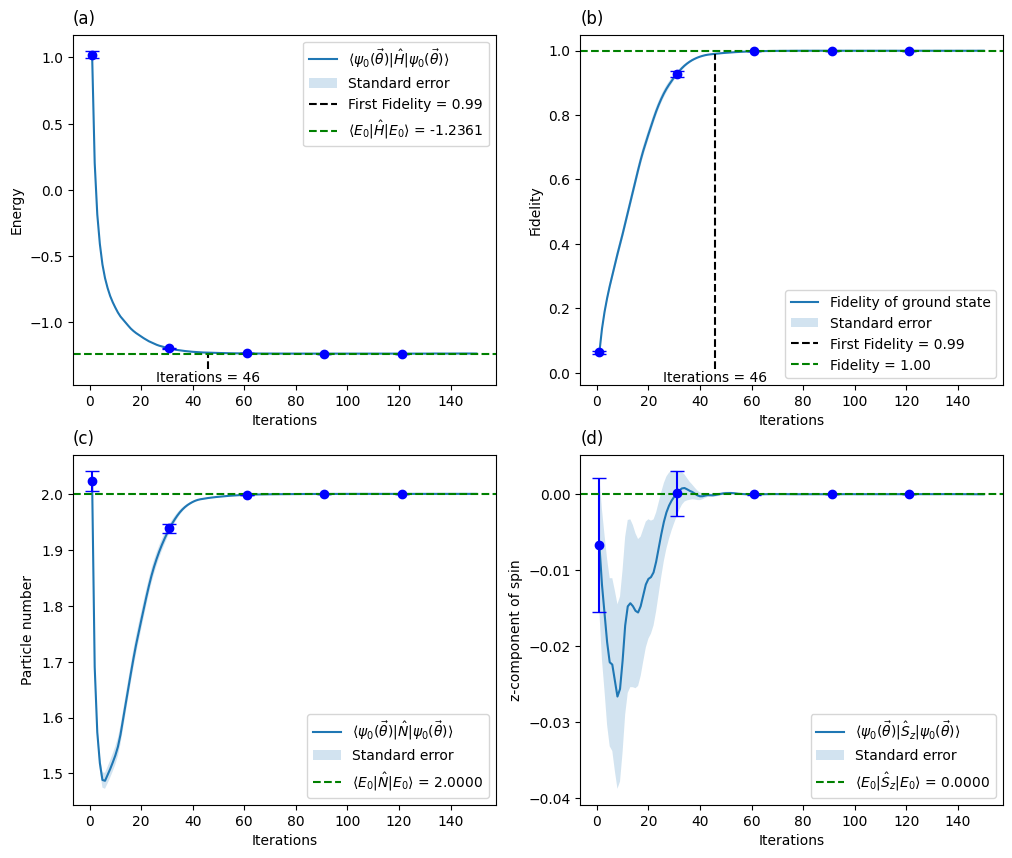

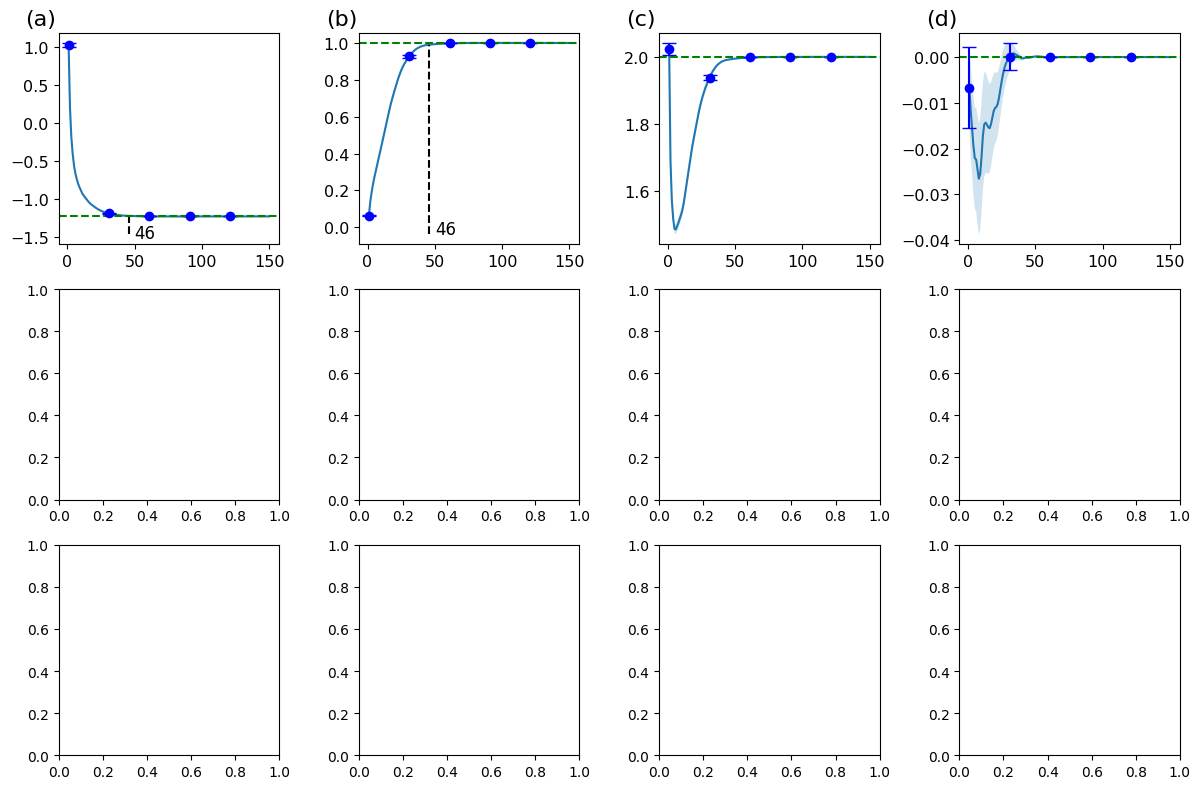

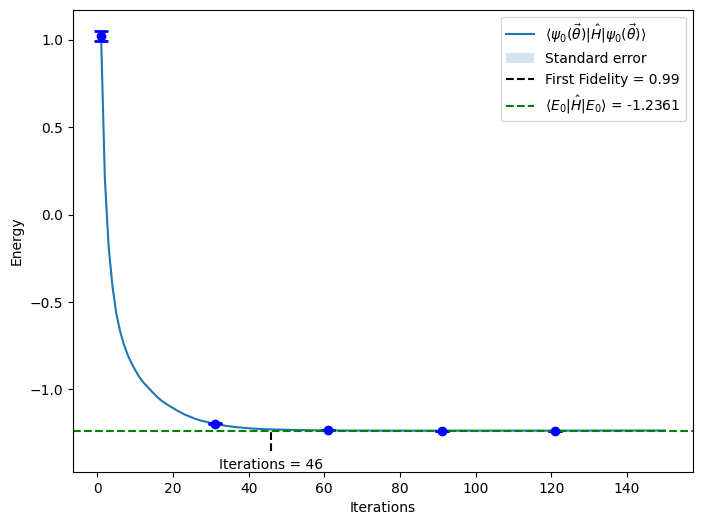

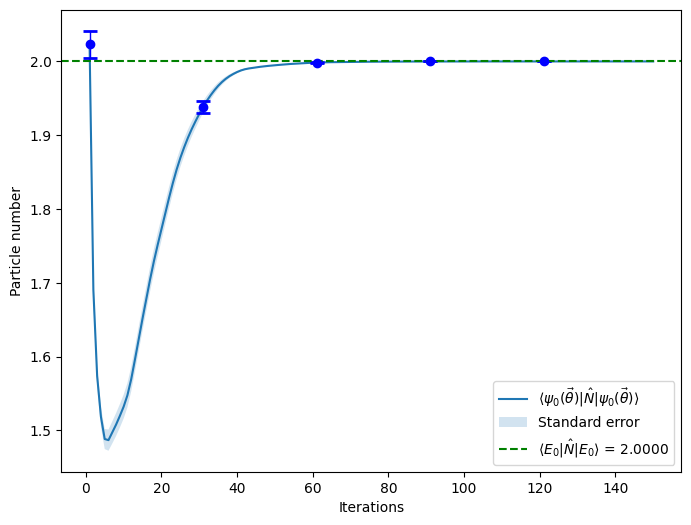

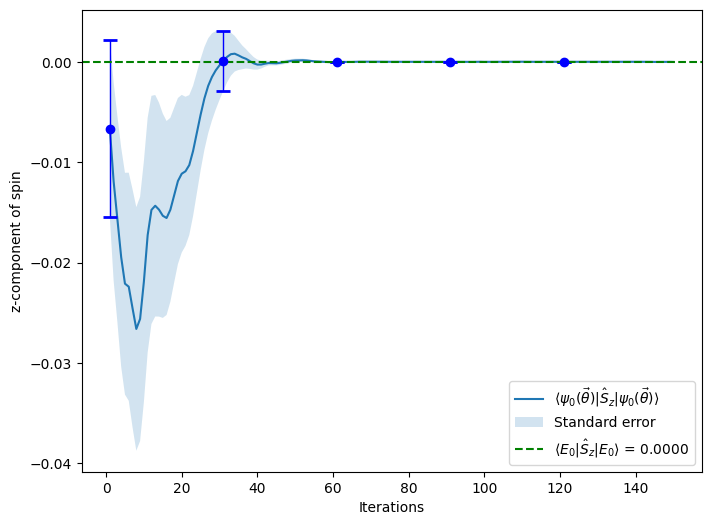

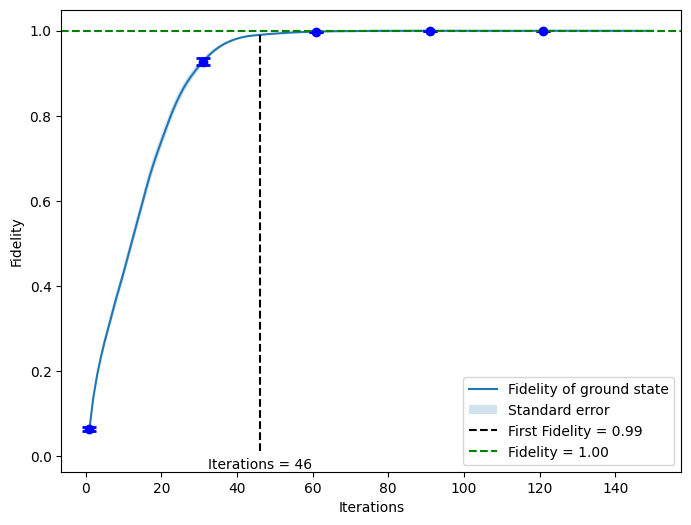

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 300)
iter_max = 150

# The fidelity corresponding to the vertical dashed line
fv = 0.99

process = '1D_Hea_g'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Hea_g_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig_12, axs_12 = plt.subplots(3, 4, figsize=(12, 8))

# Energy values plot
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[0, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[0, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[0, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[0, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[0, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[0, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    if energy_at_fidelity_one is not None:
        axs[0, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 0].text(fidelity_first_one, axs[0, 0].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[0, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--')
        axs_12[0, 0].text(fidelity_first_one + 4, axs[0, 0].get_ylim()[0] - 0.1, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 0].axhline(y=-1.2361, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
axs[0, 0].set_title('(a)', loc='left', pad=8)
axs[0, 0].set_xlabel('Iterations')
axs[0, 0].set_ylabel('Energy')
axs[0, 0].legend()
axs[0, 0].grid(False)

axs_12[0, 0].axhline(y=-1.2361, color='g', linestyle='--')
axs_12[0, 0].tick_params(axis='x', labelsize=11.5)
axs_12[0, 0].tick_params(axis='y', labelsize=11.5)
axs_12[0, 0].set_title('(a)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[0, 0].grid(False)

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[0, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    axs[0, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    axs[0, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
    axs_12[0, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0)
    axs_12[0, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
    axs_12[0, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[0, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 1].text(fidelity_first_one, axs[0, 1].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[0, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--')
        axs_12[0, 1].text(fidelity_first_one + 4, axs[0, 1].get_ylim()[0] - 0.02, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 1].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[0, 1].set_title('(b)', loc='left', pad=8)
axs[0, 1].set_xlabel('Iterations')
axs[0, 1].set_ylabel('Fidelity')
axs[0, 1].legend()
axs[0, 1].grid(False)

axs_12[0, 1].axhline(y=1.00, color='g', linestyle='--')
axs_12[0, 1].tick_params(axis='x', labelsize=11.5)
axs_12[0, 1].tick_params(axis='y', labelsize=11.5)
axs_12[0, 1].set_title('(b)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[0, 1].grid(False)

# Particle number plot
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[0, 2].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[0, 2].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[0, 2].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 0].axhline(y=2.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
axs[1, 0].set_title('(c)', loc='left', pad=8)
axs[1, 0].set_xlabel('Iterations')
axs[1, 0].set_ylabel('Particle number')
axs[1, 0].legend()
axs[1, 0].grid(False)

axs_12[0, 2].axhline(y=2.0000, color='g', linestyle='--')
axs_12[0, 2].tick_params(axis='x', labelsize=11.5)
axs_12[0, 2].tick_params(axis='y', labelsize=11.5)
axs_12[0, 2].set_title('(c)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[0, 2].grid(False)

# z-component of spin plot
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[0, 3].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[0, 3].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[0, 3].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 1].axhline(y=0.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
axs[1, 1].set_title('(d)', loc='left', pad=8)
axs[1, 1].set_xlabel('Iterations')
axs[1, 1].set_ylabel('z-component of spin')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(False)

axs_12[0, 3].axhline(y=0.0000, color='g', linestyle='--')
axs_12[0, 3].tick_params(axis='x', labelsize=11.5)
axs_12[0, 3].tick_params(axis='y', labelsize=11.5)
axs_12[0, 3].set_title('(d)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[0, 3].grid(False)

plt.tight_layout()
plt.show()

# Plot the graph: E vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

# Get the corresponding energy value for the first fidelity = fv iteration
if fidelity_first_one is not None:
    # Find the energy curve that corresponds to this iteration
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    # Plot a vertical dashed line from the energy curve to the x-axis
    if energy_at_fidelity_one is not None:
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=energy_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=-1.2361, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=2.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=0.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat1_g:

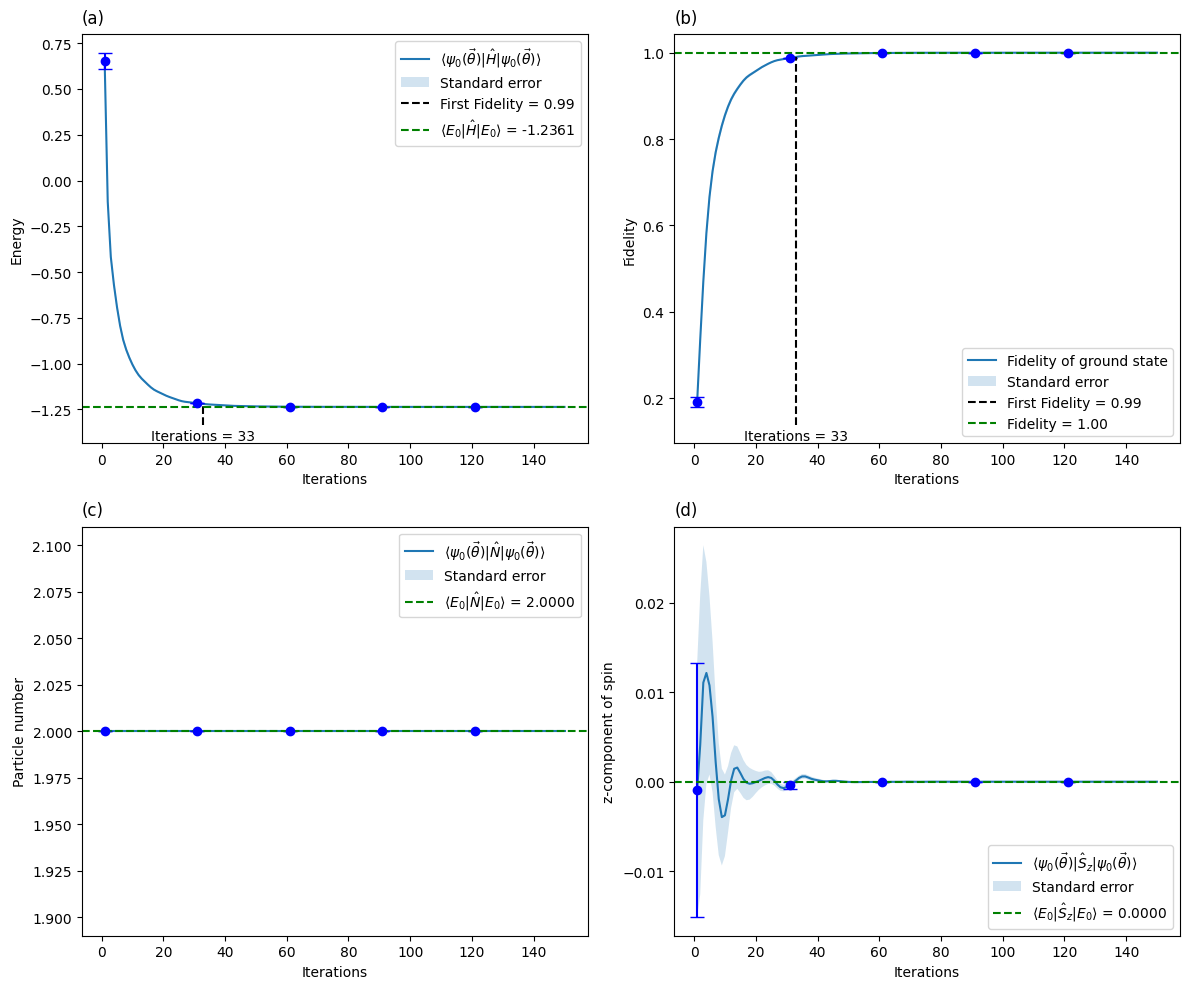

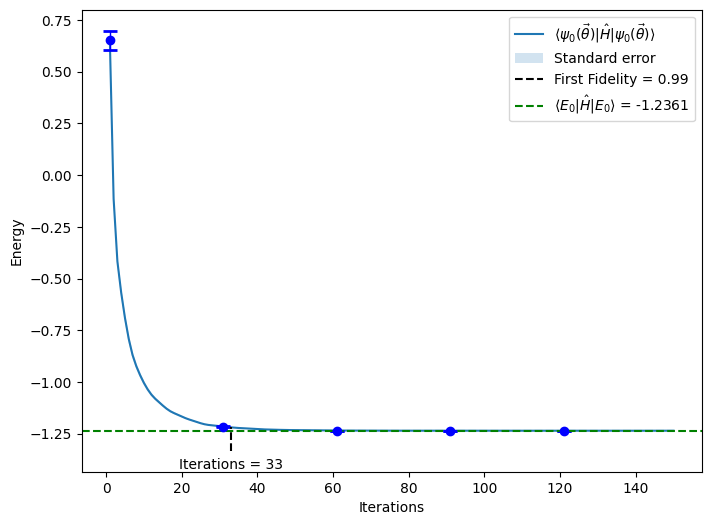

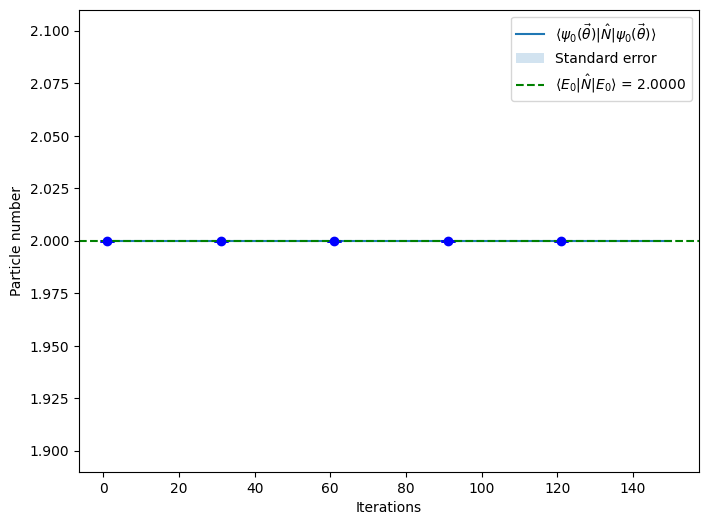

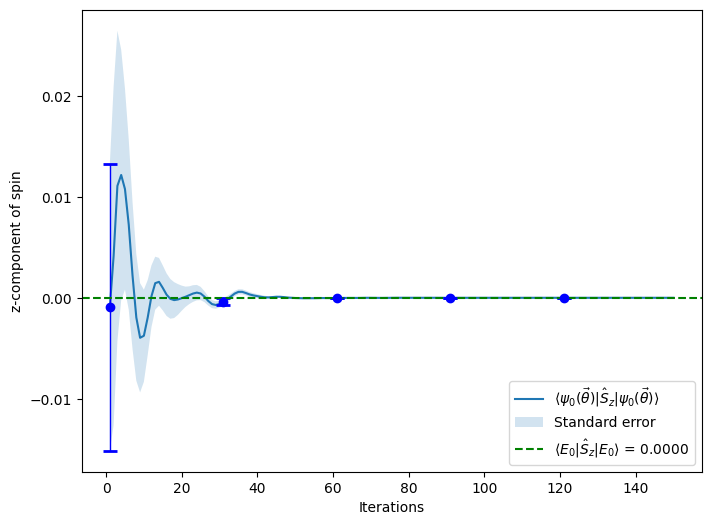

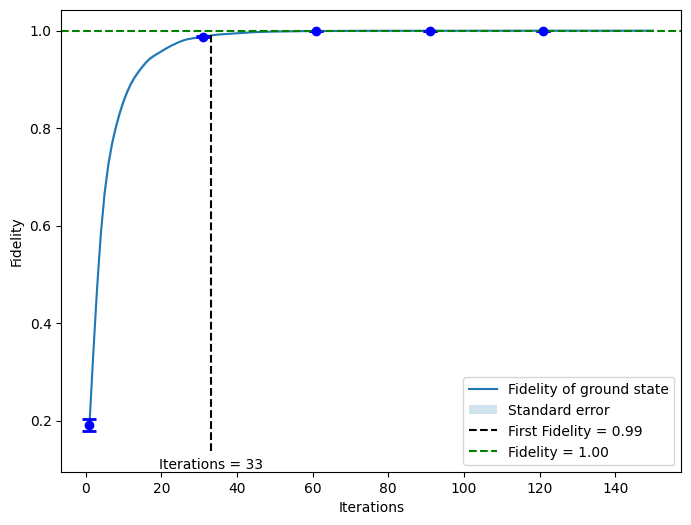

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 300)
iter_max = 150

# The fidelity corresponding to the vertical dashed line
fv = 0.99

process = '1D_Spat1_g'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Spat1_g_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Energy values plot
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[0, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[0, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[0, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[1, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[1, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[1, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    if energy_at_fidelity_one is not None:
        axs[0, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 0].text(fidelity_first_one, axs[0, 0].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[1, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--')
        axs_12[1, 0].text(fidelity_first_one + 4, axs[0, 0].get_ylim()[0] - 0.1, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 0].axhline(y=-1.2361, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
axs[0, 0].set_title('(a)', loc='left', pad=8)
axs[0, 0].set_xlabel('Iterations')
axs[0, 0].set_ylabel('Energy')
axs[0, 0].legend()
axs[0, 0].grid(False)

axs_12[1, 0].axhline(y=-1.2361, color='g', linestyle='--')
axs_12[1, 0].tick_params(axis='x', labelsize=11.5)
axs_12[1, 0].tick_params(axis='y', labelsize=11.5)
axs_12[1, 0].set_title('(e)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[1, 0].set_ylabel('Energy', fontsize=15)
axs_12[1, 0].grid(False)

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[0, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    axs[0, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    axs[0, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
    axs_12[1, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0)
    axs_12[1, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
    axs_12[1, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[0, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 1].text(fidelity_first_one, axs[0, 1].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[1, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--')
        axs_12[1, 1].text(fidelity_first_one + 4, axs[0, 1].get_ylim()[0] - 0.02, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 1].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[0, 1].set_title('(b)', loc='left', pad=8)
axs[0, 1].set_xlabel('Iterations')
axs[0, 1].set_ylabel('Fidelity')
axs[0, 1].legend()
axs[0, 1].grid(False)

axs_12[1, 1].axhline(y=1.00, color='g', linestyle='--')
axs_12[1, 1].tick_params(axis='x', labelsize=11.5)
axs_12[1, 1].tick_params(axis='y', labelsize=11.5)
axs_12[1, 1].set_title('(f)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[1, 1].set_ylabel('Fidelity', fontsize=15)
axs_12[1, 1].grid(False)

# Particle number plot
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[1, 2].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[1, 2].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[1, 2].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 0].axhline(y=2.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
axs[1, 0].set_title('(c)', loc='left', pad=8)
axs[1, 0].set_xlabel('Iterations')
axs[1, 0].set_ylabel('Particle number')
axs[1, 0].legend()
axs[1, 0].grid(False)

axs_12[1, 2].axhline(y=2.0000, color='g', linestyle='--')
axs_12[1, 2].tick_params(axis='x', labelsize=11.5)
axs_12[1, 2].tick_params(axis='y', labelsize=11.5)
axs_12[1, 2].set_title('(g)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[1, 2].set_ylabel('Particle number', fontsize=15)
axs_12[1, 2].grid(False)

# z-component of spin plot
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[1, 3].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[1, 3].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[1, 3].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 1].axhline(y=0.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
axs[1, 1].set_title('(d)', loc='left', pad=8)
axs[1, 1].set_xlabel('Iterations')
axs[1, 1].set_ylabel('z-component of spin')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(False)

axs_12[1, 3].axhline(y=0.0000, color='g', linestyle='--')
axs_12[1, 3].tick_params(axis='x', labelsize=11.5)
axs_12[1, 3].tick_params(axis='y', labelsize=11.5)
axs_12[1, 3].set_title('(h)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[1, 3].set_ylabel('z-component of spin', fontsize=15, labelpad=-2)
axs_12[1, 3].grid(False)

plt.tight_layout()
plt.show()

# Plot the graph: E vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

# Get the corresponding energy value for the first fidelity = fv iteration
if fidelity_first_one is not None:
    # Find the energy curve that corresponds to this iteration
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    # Plot a vertical dashed line from the energy curve to the x-axis
    if energy_at_fidelity_one is not None:
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=energy_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=-1.2361, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=2.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=0.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_g:

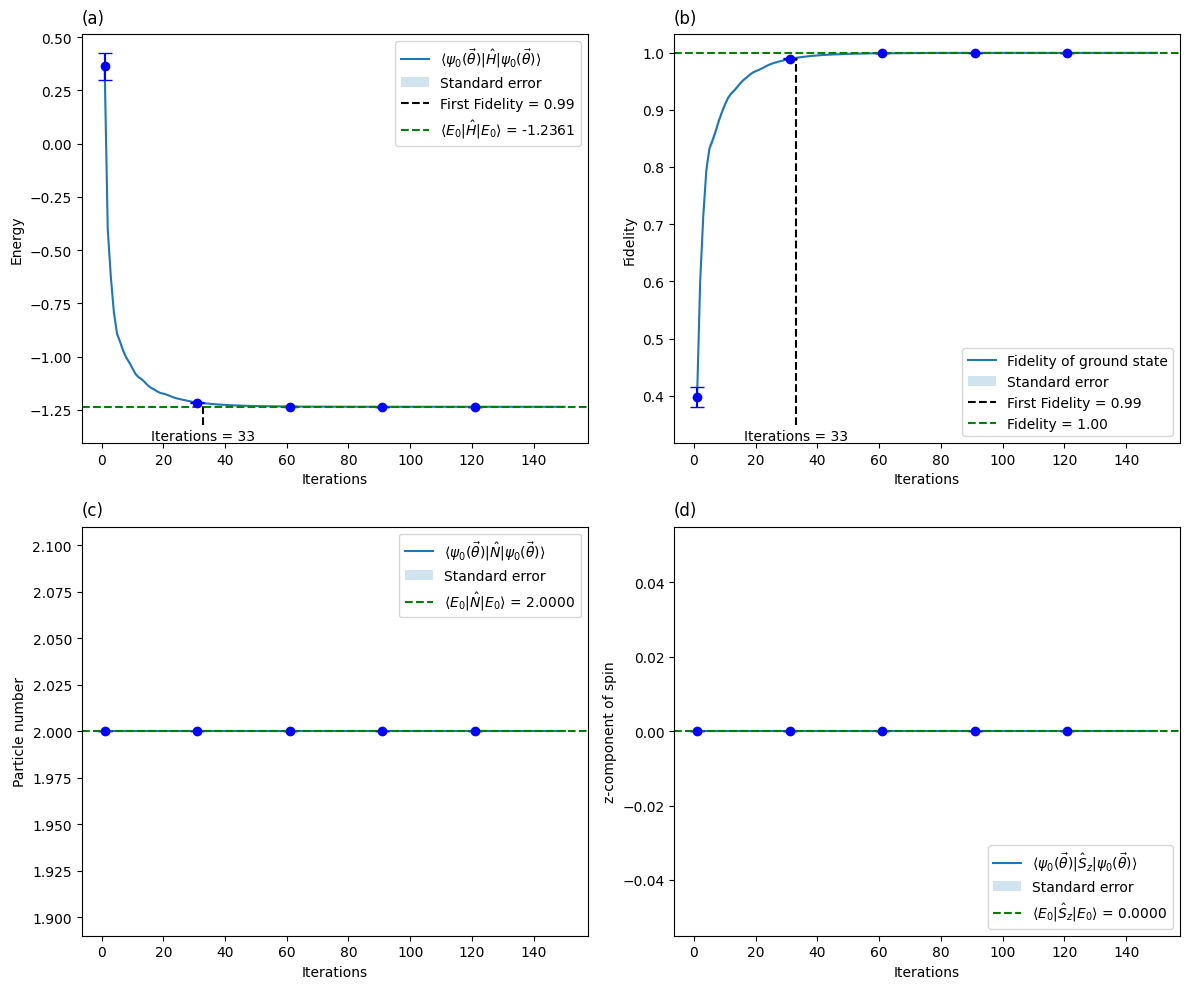

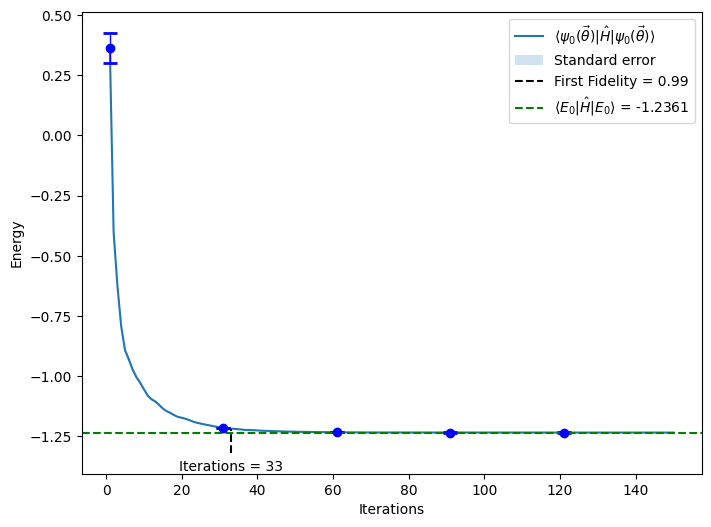

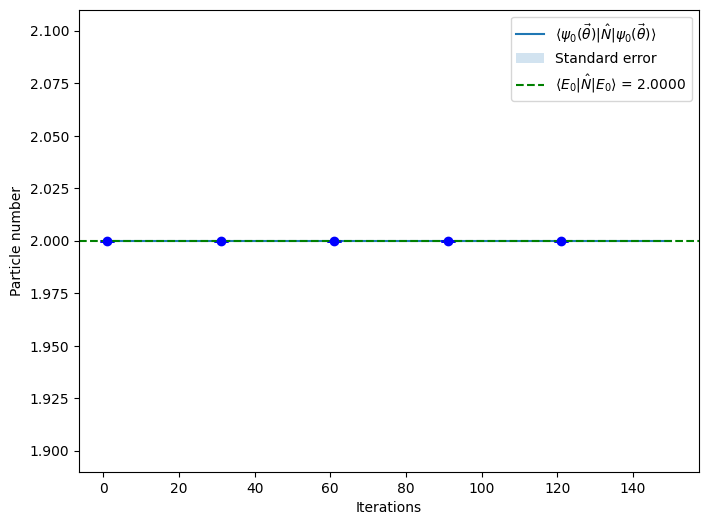

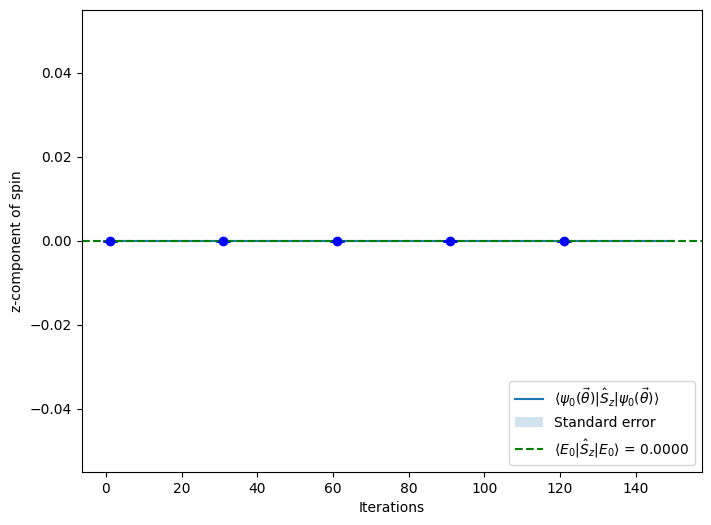

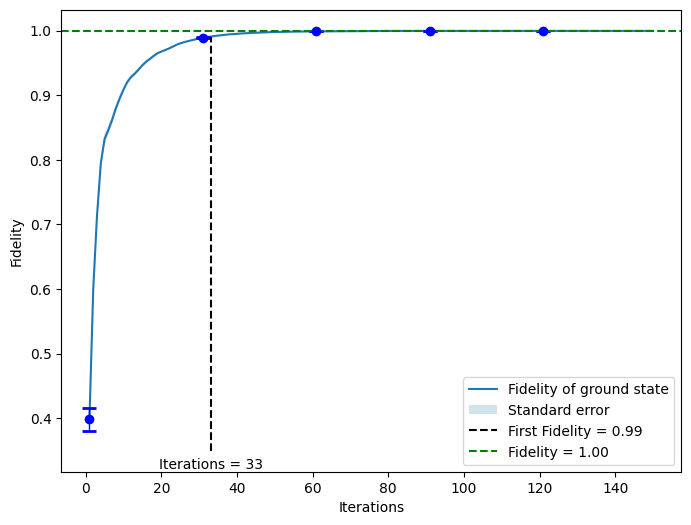

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 300)
iter_max = 150

# The fidelity corresponding to the vertical dashed line
fv = 0.99

process = '1D_Spat2_g'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Spat2_g_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Energy values plot
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[0, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[0, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[0, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[2, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[2, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[2, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    if energy_at_fidelity_one is not None:
        axs[0, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 0].text(fidelity_first_one, axs[0, 0].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[2, 0].vlines(x=fidelity_first_one, ymin=axs[0, 0].get_ylim()[0], ymax=energy_at_fidelity_one,
                         color='black', linestyle='--')
        axs_12[2, 0].text(fidelity_first_one + 4, axs[0, 0].get_ylim()[0] - 0.1, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 0].axhline(y=-1.2361, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
axs[0, 0].set_title('(a)', loc='left', pad=8)
axs[0, 0].set_xlabel('Iterations')
axs[0, 0].set_ylabel('Energy')
axs[0, 0].legend()
axs[0, 0].grid(False)

axs_12[2, 0].axhline(y=-1.2361, color='g', linestyle='--')
axs_12[2, 0].tick_params(axis='x', labelsize=11.5)
axs_12[2, 0].tick_params(axis='y', labelsize=11.5)
axs_12[2, 0].set_title('(i)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[2, 0].grid(False)

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[0, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    axs[0, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    axs[0, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
    axs_12[2, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0)
    axs_12[2, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
    axs_12[2, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[0, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=f'First Fidelity = {fv}')
        axs[0, 1].text(fidelity_first_one, axs[0, 1].get_ylim()[0], f'Iterations = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')
        axs_12[2, 1].vlines(x=fidelity_first_one, ymin=axs[0, 1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--')
        axs_12[2, 1].text(fidelity_first_one + 4, axs[0, 1].get_ylim()[0] - 0.02, f'{fidelity_first_one}', 
                       color='black', ha='left', va='bottom', fontsize=12)

axs[0, 1].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[0, 1].set_title('(b)', loc='left', pad=8)
axs[0, 1].set_xlabel('Iterations')
axs[0, 1].set_ylabel('Fidelity')
axs[0, 1].legend()
axs[0, 1].grid(False)

axs_12[2, 1].axhline(y=1.00, color='g', linestyle='--')
axs_12[2, 1].tick_params(axis='x', labelsize=11.5)
axs_12[2, 1].tick_params(axis='y', labelsize=11.5)
axs_12[2, 1].set_title('(j)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[2, 1].grid(False)

# Particle number plot
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[2, 2].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[2, 2].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[2, 2].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 0].axhline(y=2.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
axs[1, 0].set_title('(c)', loc='left', pad=8)
axs[1, 0].set_xlabel('Iterations')
axs[1, 0].set_ylabel('Particle number')
axs[1, 0].legend()
axs[1, 0].grid(False)

axs_12[2, 2].axhline(y=2.0000, color='g', linestyle='--')
axs_12[2, 2].tick_params(axis='x', labelsize=11.5)
axs_12[2, 2].tick_params(axis='y', labelsize=11.5)
axs_12[2, 2].set_title('(k)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[2, 2].grid(False)

# z-component of spin plot
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)
        lower_bound = means - errors
        upper_bound = means + errors
        
        axs[1, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                       label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        axs[1, 1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        axs[1, 1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)
        axs_12[2, 3].plot(iterations, means, linestyle='-', marker='o', markersize=0)
        axs_12[2, 3].fill_between(iterations, lower_bound, upper_bound, alpha=0.2)
        axs_12[2, 3].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                           yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

axs[1, 1].axhline(y=0.0000, color='g', linestyle='--', label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
axs[1, 1].set_title('(d)', loc='left', pad=8)
axs[1, 1].set_xlabel('Iterations')
axs[1, 1].set_ylabel('z-component of spin')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(False)

axs_12[2, 3].axhline(y=0.0000, color='g', linestyle='--')
axs_12[2, 3].tick_params(axis='x', labelsize=11.5)
axs_12[2, 3].tick_params(axis='y', labelsize=11.5)
axs_12[2, 3].set_title('(l)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_12[2, 3].grid(False)

plt.tight_layout()
#fig_12.subplots_adjust(wspace=0.5)
save_dir = os.path.expanduser('~/Desktop/Picture')
os.makedirs(save_dir, exist_ok=True)

#fig_save_path = os.path.join(save_dir, f"{process}_4.pdf")
#fig.savefig(fig_save_path, format='pdf', dpi=300)

fig_12.text(0.5, 0.0, 'Iterations', ha='center', va='top', fontsize=16.5)
fig_12_save_path = os.path.join(save_dir, f'1D_ground_state.pdf')
fig_12.savefig(fig_12_save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot the graph: E vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{H}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

# Get the corresponding energy value for the first fidelity = fv iteration
if fidelity_first_one is not None:
    # Find the energy curve that corresponds to this iteration
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

    # Plot a vertical dashed line from the energy curve to the x-axis
    if energy_at_fidelity_one is not None:
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=energy_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=-1.2361, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{H}\vert E_{0}\rangle$ = -1.2361')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{N}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=2.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{N}\vert E_{0}\rangle$ = 2.0000')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        lower_bound = means - errors
        upper_bound = means + errors

        # Plot the means and error bars
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}(\vec{{\theta}})\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}(\vec{{\theta}})\rangle$')
        plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
        plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                     capsize=5, elinewidth=1, capthick=2)

plt.axhline(y=0.0000, color='g', linestyle='--', 
            label=r'$\langle E_{0}\vert\hat{S}_{z}\vert E_{0}\rangle$ = 0.0000')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=f'First Fidelity = {fv}')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Hea_ae:

The first iteration where Fidelity_excited_15 reaches or exceeds fidelity 0.6 is at iteration 44
The first iteration where Fidelity_ground reaches or exceeds fidelity 0.6 is at iteration 68
The first iteration where Fidelity_excited_5 reaches or exceeds fidelity 0.6 is at iteration 75
The first iteration where Fidelity_excited_11 reaches or exceeds fidelity 0.6 is at iteration 89
The first iteration where Fidelity_excited_8 reaches or exceeds fidelity 0.6 is at iteration 90
The first iteration where Fidelity_excited_14 reaches or exceeds fidelity 0.6 is at iteration 91
The first iteration where Fidelity_excited_1 reaches or exceeds fidelity 0.6 is at iteration 93
The first iteration where Fidelity_excited_2 reaches or exceeds fidelity 0.6 is at iteration 95
The first iteration where Fidelity_excited_10 reaches or exceeds fidelity 0.6 is at iteration 99
The first iteration where Fidelity_excited_13 reaches or exceeds fidelity 0.6 is at iteration 104
The first iteration where Fidelity_ex

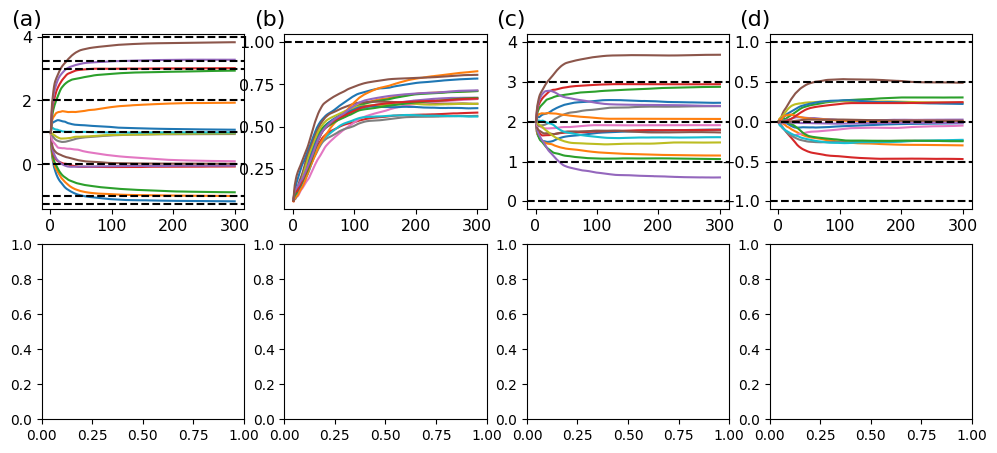

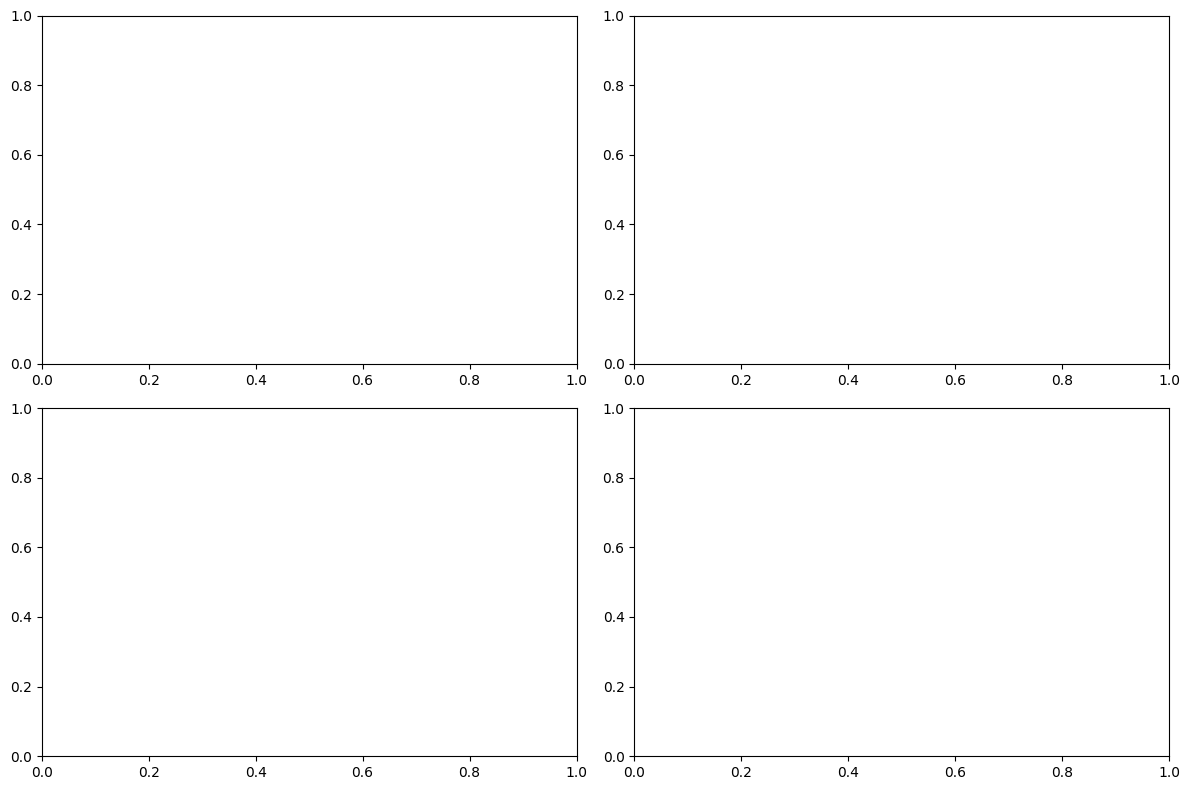

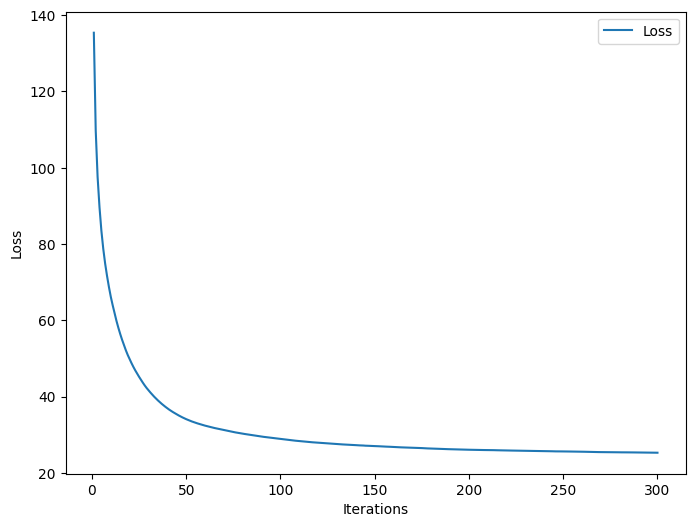

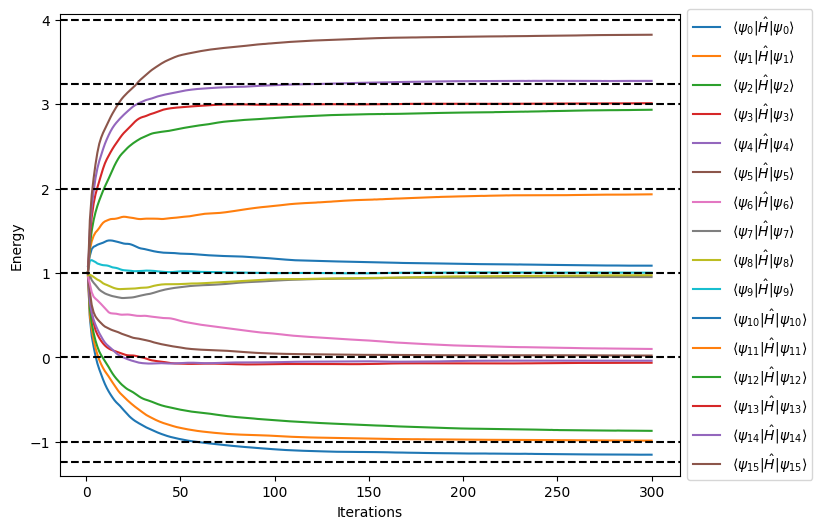

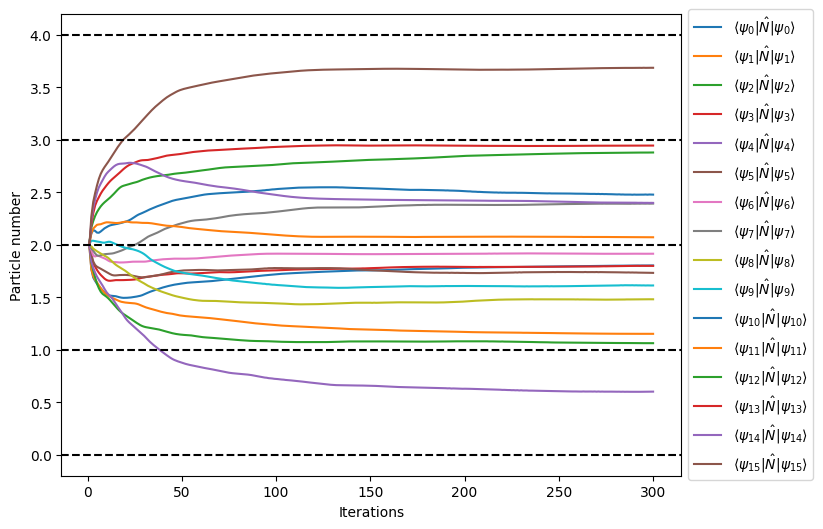

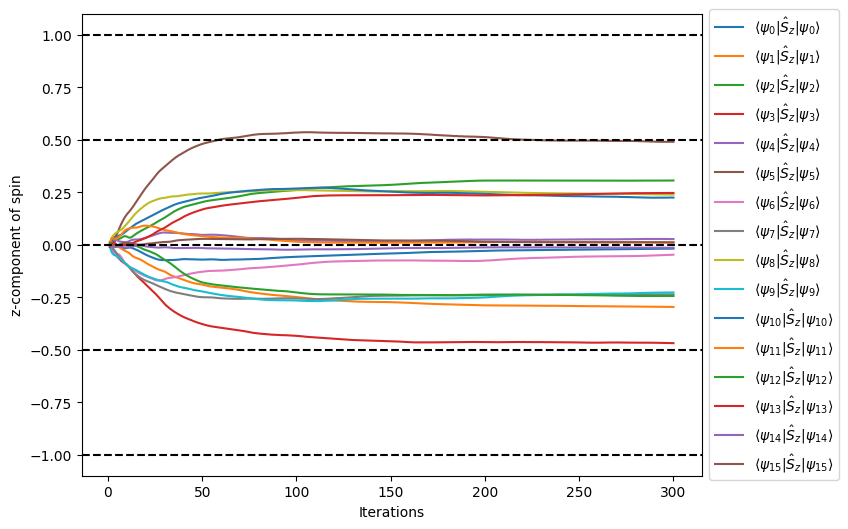

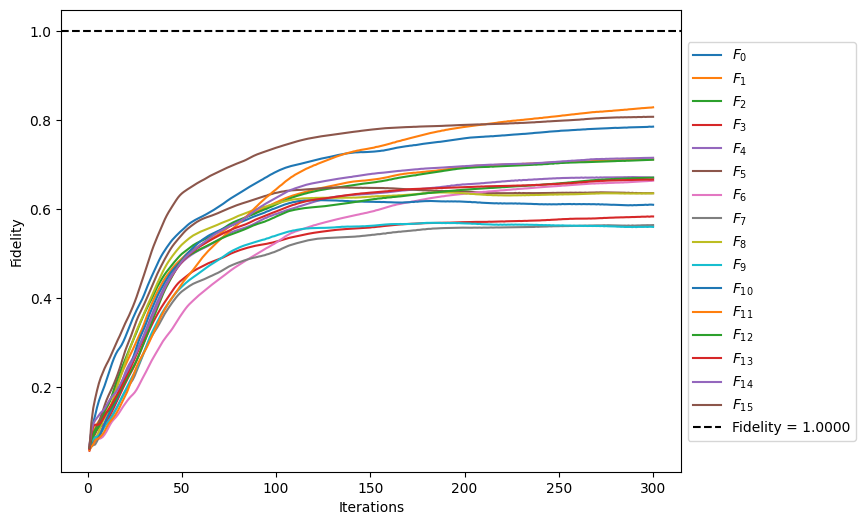

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Hea_ae'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.60
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig_8, axs_8 = plt.subplots(2, 4, figsize=(12, 5))
fig_4L, axs_4L = plt.subplots(2, 2, figsize=(12, 8))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[0, 0].plot(iterations, means)

#axs[0, 0].axhline(y=-1.2361, color='black', linestyle='--')
#axs[0, 0].axhline(y=-1.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=0.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=1.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=3.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=3.2361, color='black', linestyle='--')
#axs[0, 0].axhline(y=4.0000, color='black', linestyle='--')
#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_8[0, 0].axhline(y=-1.2361, color='black', linestyle='--')
axs_8[0, 0].axhline(y=-1.0000, color='black', linestyle='--')
axs_8[0, 0].axhline(y=0.0000, color='black', linestyle='--')
axs_8[0, 0].axhline(y=1.0000, color='black', linestyle='--')
axs_8[0, 0].axhline(y=2.0000, color='black', linestyle='--')
axs_8[0, 0].axhline(y=3.0000, color='black', linestyle='--')
axs_8[0, 0].axhline(y=3.2361, color='black', linestyle='--')
axs_8[0, 0].axhline(y=4.0000, color='black', linestyle='--')
axs_8[0, 0].tick_params(axis='x', labelsize=11.5)
axs_8[0, 0].tick_params(axis='y', labelsize=11.5)
axs_8[0, 0].set_title('(a)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_8[0, 1].plot(iterations, means)
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        #axs[0, 1].plot(iterations, means, label=rf'$F_{{{idx}}}$')
        axs_8[0, 1].plot(iterations, means)

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_8[0, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_8[0, 1].tick_params(axis='x', labelsize=11.5)
axs_8[0, 1].tick_params(axis='y', labelsize=11.5)
axs_8[0, 1].set_title('(b)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[0, 2].plot(iterations, means)

#axs[1, 0].axhline(y=0.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=1.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=3.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=4.0000, color='black', linestyle='--')
#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[1, 0].set_title('(c)', loc='left', pad=8)

axs_8[0, 2].axhline(y=0.0000, color='black', linestyle='--')
axs_8[0, 2].axhline(y=1.0000, color='black', linestyle='--')
axs_8[0, 2].axhline(y=2.0000, color='black', linestyle='--')
axs_8[0, 2].axhline(y=3.0000, color='black', linestyle='--')
axs_8[0, 2].axhline(y=4.0000, color='black', linestyle='--')
axs_8[0, 2].tick_params(axis='x', labelsize=11.5)
axs_8[0, 2].tick_params(axis='y', labelsize=11.5)
axs_8[0, 2].set_title('(c)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[0, 3].plot(iterations, means)

#axs[1, 1].axhline(y=-1.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=-0.5000, color='black', linestyle='--')
#axs[1, 1].axhline(y=0.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=0.5000, color='black', linestyle='--')
#axs[1, 1].axhline(y=1.0000, color='black', linestyle='--')
#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[1, 1].set_title('(d)', loc='left', pad=8)

axs_8[0, 3].axhline(y=-1.0000, color='black', linestyle='--')
axs_8[0, 3].axhline(y=-0.5000, color='black', linestyle='--')
axs_8[0, 3].axhline(y=0.0000, color='black', linestyle='--')
axs_8[0, 3].axhline(y=0.5000, color='black', linestyle='--')
axs_8[0, 3].axhline(y=1.0000, color='black', linestyle='--')
axs_8[0, 3].tick_params(axis='x', labelsize=11.5)
axs_8[0, 3].tick_params(axis='y', labelsize=11.5)
axs_8[0, 3].set_title('(d)', loc='left', pad=6, x=-0.15, fontsize=16)

plt.tight_layout()
#save_dir = os.path.expanduser('~/Desktop/Picture')
#os.makedirs(save_dir, exist_ok=True)
#fig_save_path = os.path.join(save_dir, f"{process}_4_2.pdf")
#fig.savefig(fig_save_path, format='pdf', dpi=300)
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')
    axs_4L[0, 0].plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

axs_4L[0, 0].set_title('(a)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_4L[0, 0].set_ylabel('Loss', fontsize=15)
axs_4L[0, 0].tick_params(axis='x', labelsize=11.5)
axs_4L[0, 0].tick_params(axis='y', labelsize=11.5)
axs_4L[0, 0].legend()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.2361, color='black', linestyle='--')
plt.axhline(y=-1.0000, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
plt.axhline(y=2.0000, color='black', linestyle='--')
plt.axhline(y=3.0000, color='black', linestyle='--')
plt.axhline(y=3.2361, color='black', linestyle='--')
plt.axhline(y=4.0000, color='black', linestyle='--')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(loc='upper right', bbox_to_anchor=(1.225, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
plt.axhline(y=2.0000, color='black', linestyle='--')
plt.axhline(y=3.0000, color='black', linestyle='--')
plt.axhline(y=4.0000, color='black', linestyle='--')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.224, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.0000, color='black', linestyle='--')
plt.axhline(y=-0.5000, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=0.5000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.232, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend(loc='upper right', bbox_to_anchor=(1.293, 0.945))
plt.grid(False)
plt.show()


In [ ]:
1D_Hea_ae_Sz:

<Figure size 640x480 with 0 Axes>

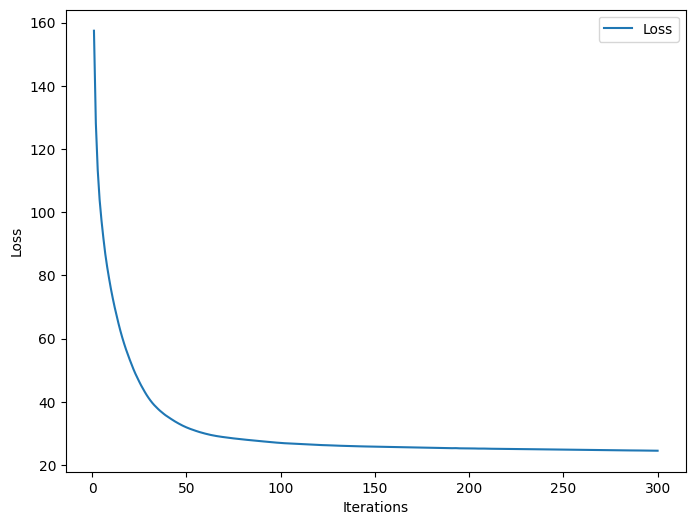

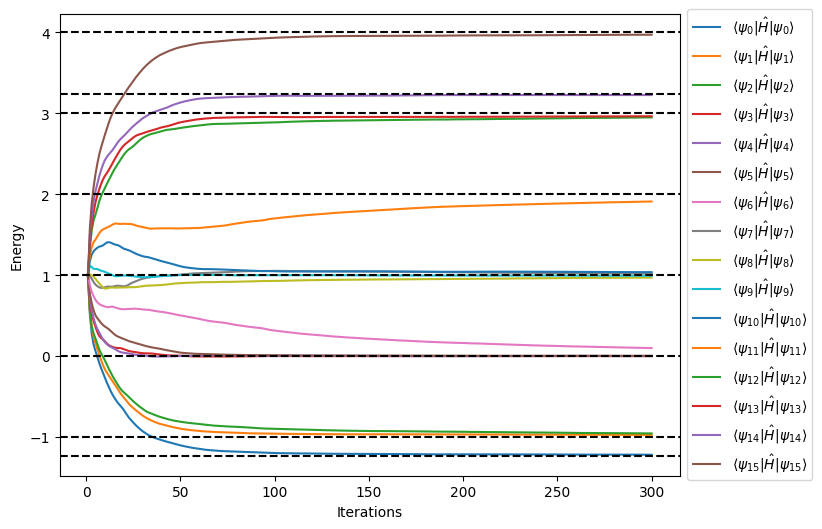

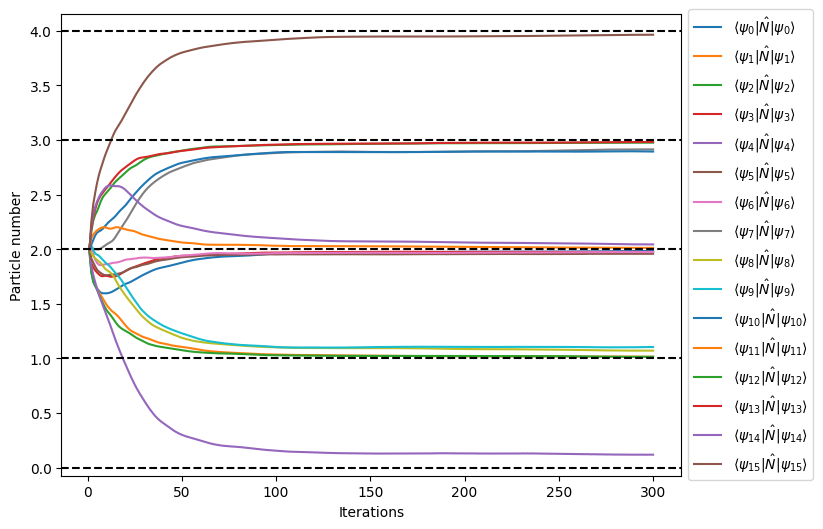

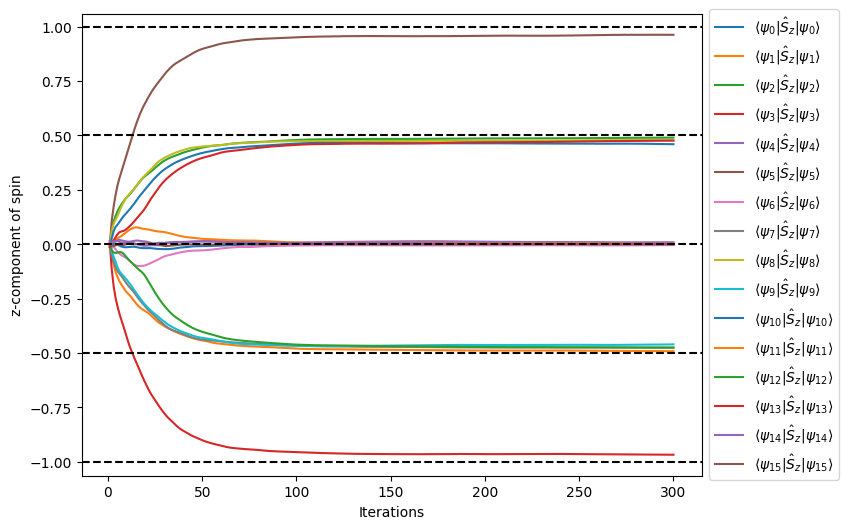

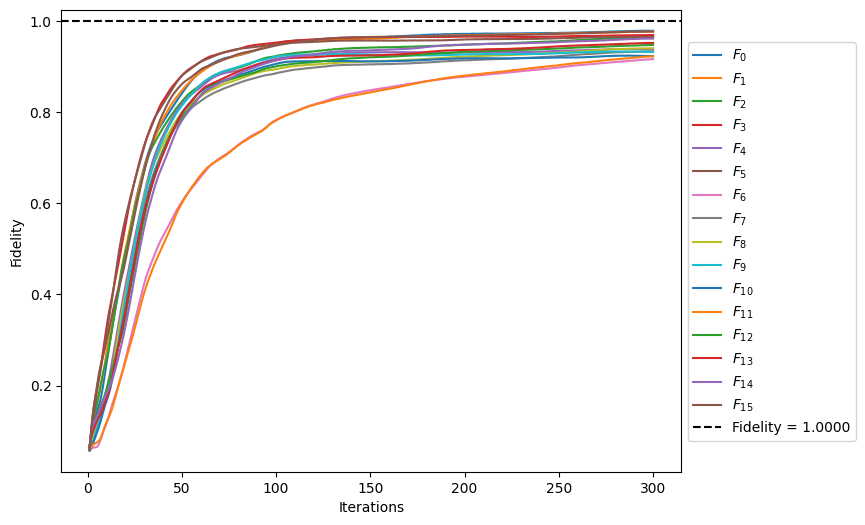

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Hea_ae_Sz'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[1, 0].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 0].axhline(y=-1.2361, color='black', linestyle='--')
#axs[0, 0].axhline(y=-1.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=0.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=1.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=3.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=3.2361, color='black', linestyle='--')
#axs[0, 0].axhline(y=4.0000, color='black', linestyle='--')
#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_8[1, 0].axhline(y=-1.2361, color='black', linestyle='--')
axs_8[1, 0].axhline(y=-1.0000, color='black', linestyle='--')
axs_8[1, 0].axhline(y=0.0000, color='black', linestyle='--')
axs_8[1, 0].axhline(y=1.0000, color='black', linestyle='--')
axs_8[1, 0].axhline(y=2.0000, color='black', linestyle='--')
axs_8[1, 0].axhline(y=3.0000, color='black', linestyle='--')
axs_8[1, 0].axhline(y=3.2361, color='black', linestyle='--')
axs_8[1, 0].axhline(y=4.0000, color='black', linestyle='--')
axs_8[1, 0].set_ylabel('Energy', fontsize=15, labelpad=16, y=1.12)
axs_8[1, 0].legend(loc='upper right', bbox_to_anchor=(4.1, -0.34), ncol=8)
axs_8[1, 0].tick_params(axis='x', labelsize=11.5)
axs_8[1, 0].tick_params(axis='y', labelsize=11.5)
axs_8[1, 0].set_title('(e)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_8[1, 1].plot(iterations, means)
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        #axs[0, 1].plot(iterations, means, label=rf'$F_{{{idx}}}$')
        axs_8[1, 1].plot(iterations, means)

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_8[1, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_8[1, 1].set_ylabel('Fidelity', fontsize=15, y=1.12)
axs_8[1, 1].tick_params(axis='x', labelsize=11.5)
axs_8[1, 1].tick_params(axis='y', labelsize=11.5)
axs_8[1, 1].set_title('(f)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[1, 2].plot(iterations, means)

#axs[1, 0].axhline(y=0.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=1.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=3.0000, color='black', linestyle='--')
#axs[1, 0].axhline(y=4.0000, color='black', linestyle='--')
#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[1, 0].set_title('(c)', loc='left', pad=8)

axs_8[1, 2].axhline(y=0.0000, color='black', linestyle='--')
axs_8[1, 2].axhline(y=1.0000, color='black', linestyle='--')
axs_8[1, 2].axhline(y=2.0000, color='black', linestyle='--')
axs_8[1, 2].axhline(y=3.0000, color='black', linestyle='--')
axs_8[1, 2].axhline(y=4.0000, color='black', linestyle='--')
axs_8[1, 2].set_ylabel('Particle number', fontsize=15, labelpad=16, y=1.12)
axs_8[1, 2].tick_params(axis='x', labelsize=11.5)
axs_8[1, 2].tick_params(axis='y', labelsize=11.5)
axs_8[1, 2].set_title('(g)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')
        axs_8[1, 3].plot(iterations, means)

#axs[1, 1].axhline(y=-1.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=-0.5000, color='black', linestyle='--')
#axs[1, 1].axhline(y=0.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=0.5000, color='black', linestyle='--')
#axs[1, 1].axhline(y=1.0000, color='black', linestyle='--')
#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
#axs[1, 1].set_title('(d)', loc='left', pad=8)

axs_8[1, 3].axhline(y=-1.0000, color='black', linestyle='--')
axs_8[1, 3].axhline(y=-0.5000, color='black', linestyle='--')
axs_8[1, 3].axhline(y=0.0000, color='black', linestyle='--')
axs_8[1, 3].axhline(y=0.5000, color='black', linestyle='--')
axs_8[1, 3].axhline(y=1.0000, color='black', linestyle='--')
axs_8[1, 3].set_ylabel('z-component of spin', fontsize=15, y=1.12)
axs_8[1, 3].tick_params(axis='x', labelsize=11.5)
axs_8[1, 3].tick_params(axis='y', labelsize=11.5)
axs_8[1, 3].set_title('(h)', loc='left', pad=6, x=-0.15, fontsize=16)

plt.tight_layout()
fig_8.subplots_adjust(wspace=0.38)
save_dir = os.path.expanduser('~/Desktop/Picture')
os.makedirs(save_dir, exist_ok=True)

#fig_save_path = os.path.join(save_dir, f"{process}_4_2.pdf")
#fig.savefig(fig_save_path, format='pdf', dpi=300)

fig_8.text(0.5, 0.0, 'Iterations', ha='center', va='top', fontsize=16.5)
fig_8_save_path = os.path.join(save_dir, f'1D_all_eigenstates.pdf')
fig_8.savefig(fig_8_save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.2361, color='black', linestyle='--')
plt.axhline(y=-1.0000, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
plt.axhline(y=2.0000, color='black', linestyle='--')
plt.axhline(y=3.0000, color='black', linestyle='--')
plt.axhline(y=3.2361, color='black', linestyle='--')
plt.axhline(y=4.0000, color='black', linestyle='--')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(loc='upper right', bbox_to_anchor=(1.225, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
plt.axhline(y=2.0000, color='black', linestyle='--')
plt.axhline(y=3.0000, color='black', linestyle='--')
plt.axhline(y=4.0000, color='black', linestyle='--')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.224, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.0000, color='black', linestyle='--')
plt.axhline(y=-0.5000, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=0.5000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.232, 1.025))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend(loc='upper right', bbox_to_anchor=(1.293, 0.945))
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_en2:

The first iteration where Fidelity_excited_14 reaches or exceeds fidelity 0.99 is at iteration 31
The first iteration where Fidelity_ground reaches or exceeds fidelity 0.99 is at iteration 70
The first iteration where Fidelity_excited_11 reaches or exceeds fidelity 0.99 is at iteration 100


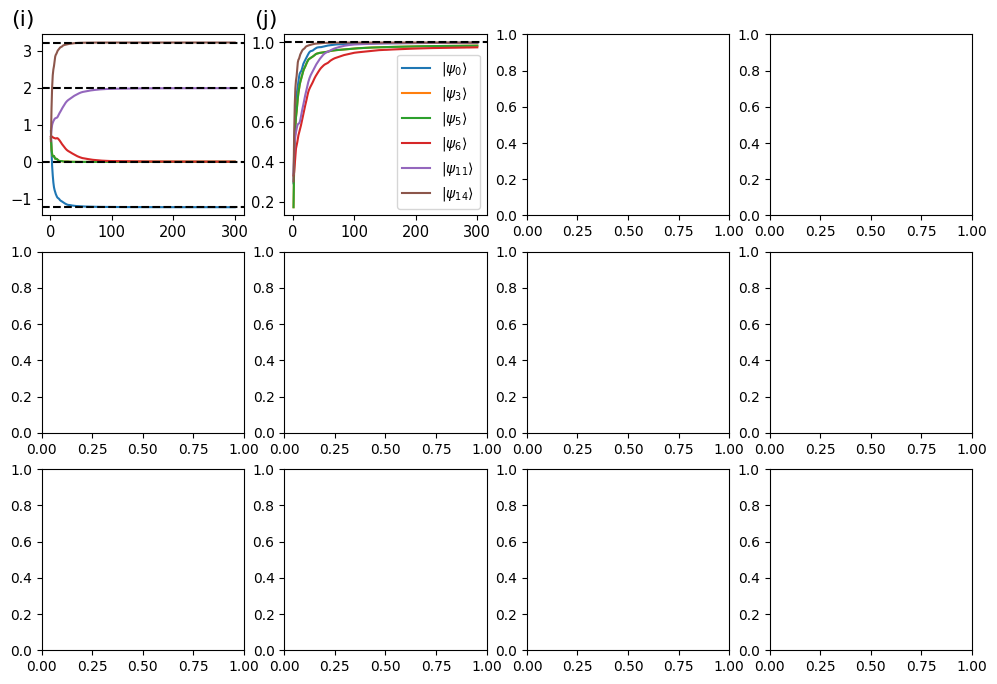

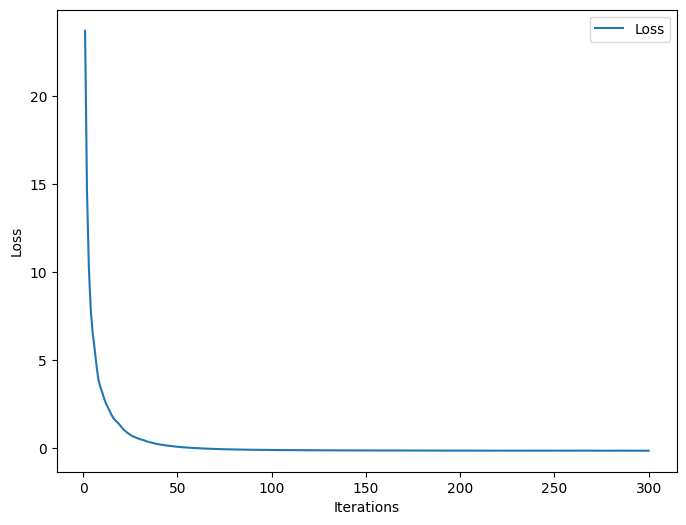

<Figure size 640x480 with 0 Axes>

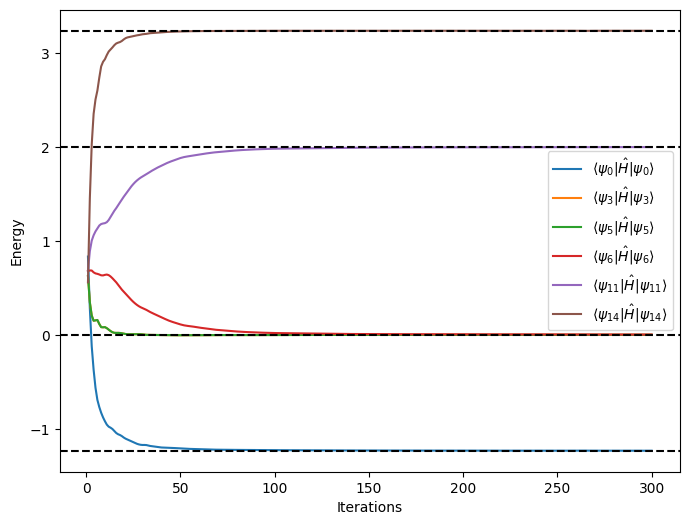

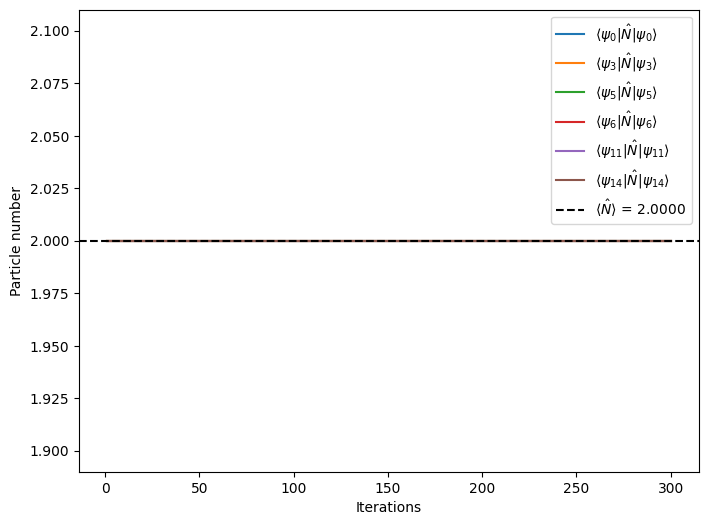

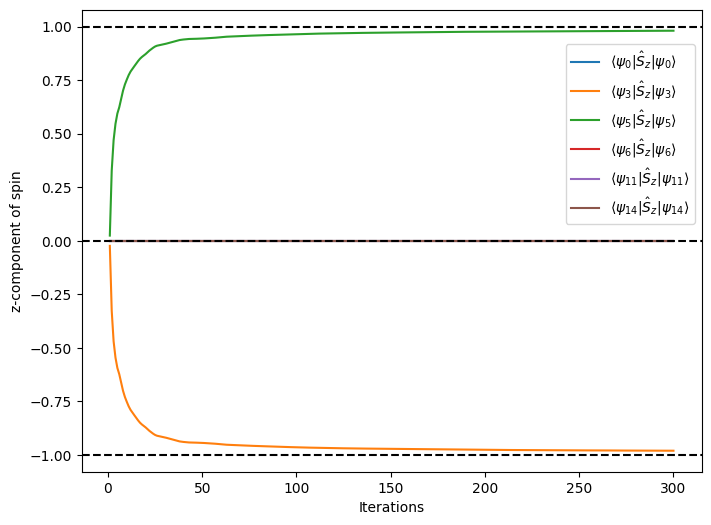

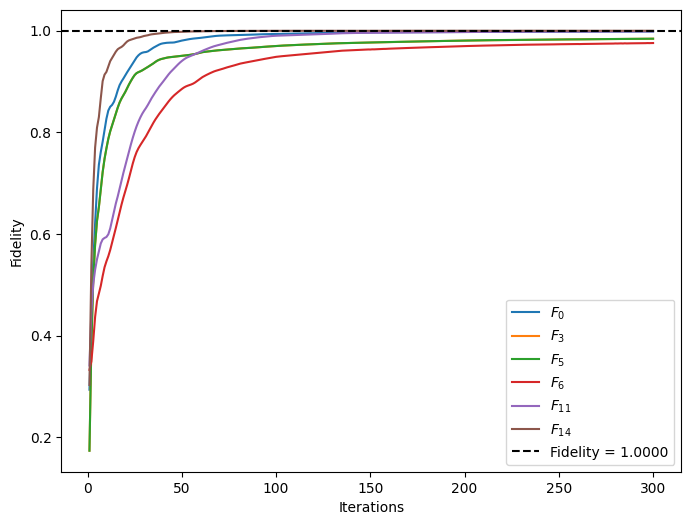

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Spat2_en2'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig_12S, axs_12S = plt.subplots(3, 4, figsize=(12, 8))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_12S[0, 0].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 0].axhline(y=-1.2361, color='black', linestyle='--')
#axs[0, 0].axhline(y=0.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[0, 0].axhline(y=3.2361, color='black', linestyle='--')
#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.00, 0.92), ncol=4, fontsize='small', markerscale=0.8)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_12S[0, 0].axhline(y=-1.2361, color='black', linestyle='--')
axs_12S[0, 0].axhline(y=0.0000, color='black', linestyle='--')
axs_12S[0, 0].axhline(y=2.0000, color='black', linestyle='--')
axs_12S[0, 0].axhline(y=3.2361, color='black', linestyle='--')
axs_12S[0, 0].tick_params(axis='x', labelsize=10.5)
axs_12S[0, 0].tick_params(axis='y', labelsize=10.5)
axs_12S[0, 0].set_title('(i)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_12S[0, 1].plot(iterations, means, label=r'$\vert\psi_{0}\rangle$')
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        axs_12S[0, 1].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend()
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_12S[0, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[0, 1].legend()
axs_12S[0, 1].tick_params(axis='x', labelsize=10.5)
axs_12S[0, 1].tick_params(axis='y', labelsize=10.5)
axs_12S[0, 1].set_title('(j)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')
        axs_4L[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 0].axhline(y=2.0000, color='black', linestyle='--')
#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend()
#axs[1, 0].set_title('(c)', loc='left', pad=8)

axs_4L[1, 0].axhline(y=2.0000, color='black', linestyle='--')
axs_4L[1, 0].set_ylabel('Particle number', fontsize=15)
axs_4L[1, 0].legend(ncol=3)
axs_4L[1, 0].tick_params(axis='x', labelsize=11.5)
axs_4L[1, 0].tick_params(axis='y', labelsize=11.5)
axs_4L[1, 0].set_title('(c)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')
        axs_4L[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 1].axhline(y=-1.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=0.0000, color='black', linestyle='--')
#axs[1, 1].axhline(y=1.0000, color='black', linestyle='--')
#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper right', bbox_to_anchor=(1.00, 0.97))
#axs[1, 1].set_title('(d)', loc='left', pad=8)

axs_4L[1, 1].axhline(y=-1.0000, color='black', linestyle='--')
axs_4L[1, 1].axhline(y=0.0000, color='black', linestyle='--')
axs_4L[1, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_4L[1, 1].set_ylabel('z-component of spin', fontsize=15)
axs_4L[1, 1].legend(loc='upper right', ncol=3, bbox_to_anchor=(1.00, 0.8))
axs_4L[1, 1].tick_params(axis='x', labelsize=11.5)
axs_4L[1, 1].tick_params(axis='y', labelsize=11.5)
axs_4L[1, 1].set_title('(d)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')
    axs_4L[0, 1].plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

axs_4L[0, 1].set_title('(b)', loc='left', pad=6, x=-0.15, fontsize=16)
axs_4L[0, 1].set_ylabel('Loss', fontsize=15)
axs_4L[0, 1].tick_params(axis='x', labelsize=11.5)
axs_4L[0, 1].tick_params(axis='y', labelsize=11.5)
axs_4L[0, 1].legend()

plt.tight_layout()
fig_4L.subplots_adjust(wspace=0.2)
save_dir = os.path.expanduser('~/Desktop/Picture')
os.makedirs(save_dir, exist_ok=True)
fig_4L.text(0.5, 0.0, 'Iterations', ha='center', va='top', fontsize=16.5)
fig_4L_save_path = os.path.join(save_dir, f'1D_loss.pdf')
fig_4L.savefig(fig_4L_save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.2361, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=2.0000, color='black', linestyle='--')
plt.axhline(y=3.2361, color='black', linestyle='--')
#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=2.0000, color='black', linestyle='--', 
            label=r'$\langle\hat{N}\rangle$ = 2.0000')
#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.00))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

plt.axhline(y=-1.0000, color='black', linestyle='--')
plt.axhline(y=0.0000, color='black', linestyle='--')
plt.axhline(y=1.0000, color='black', linestyle='--')
#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 0.94))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_en1:

The first iteration where Fidelity_excited_1 reaches or exceeds fidelity 0.99 is at iteration 43
The first iteration where Fidelity_excited_2 reaches or exceeds fidelity 0.99 is at iteration 45
The first iteration where Fidelity_excited_8 reaches or exceeds fidelity 0.99 is at iteration 53
The first iteration where Fidelity_excited_9 reaches or exceeds fidelity 0.99 is at iteration 53


<Figure size 640x480 with 0 Axes>

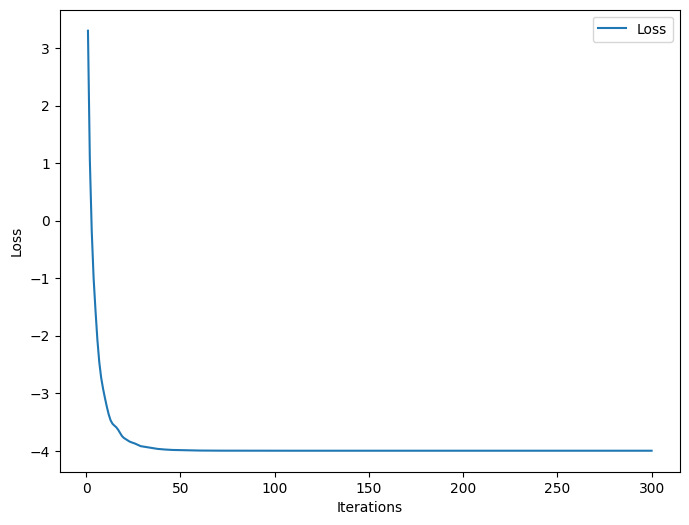

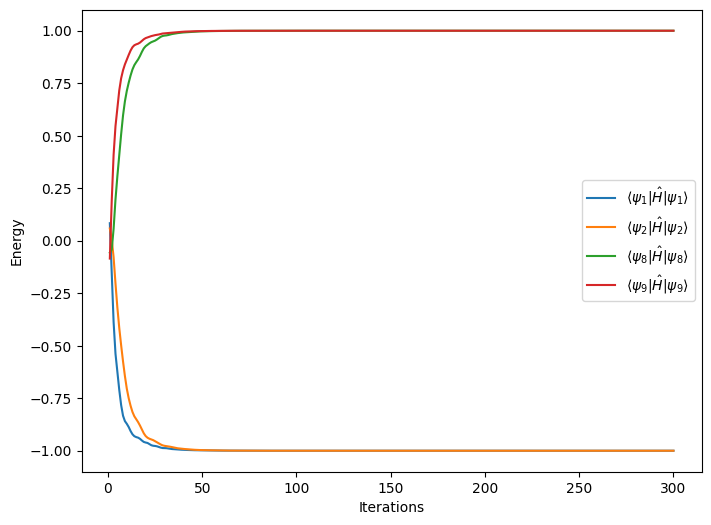

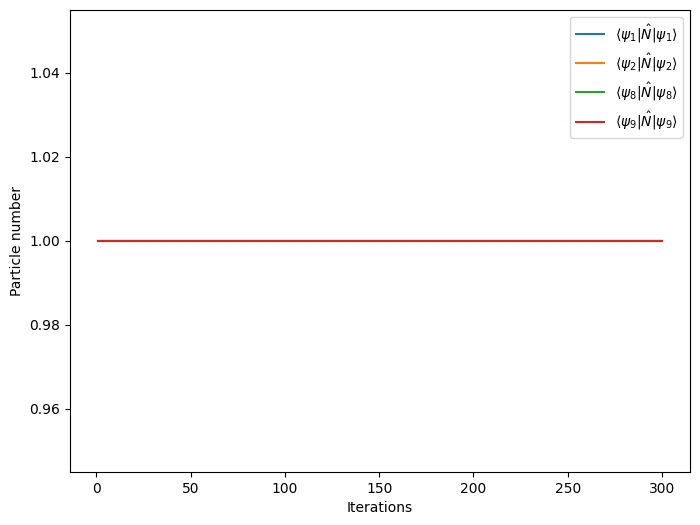

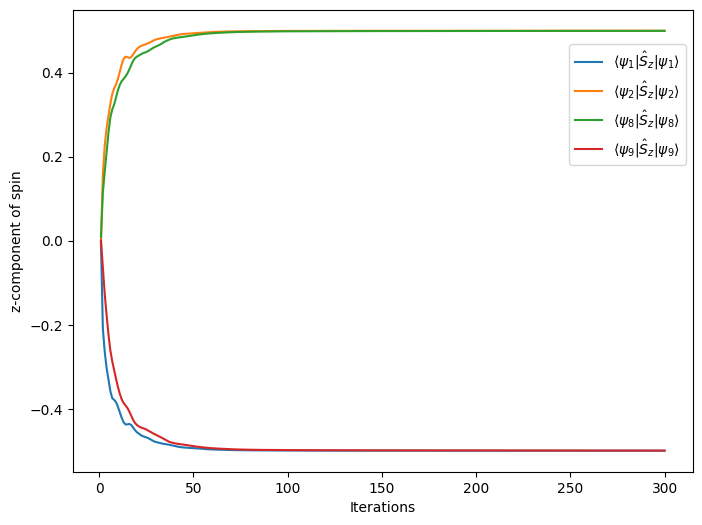

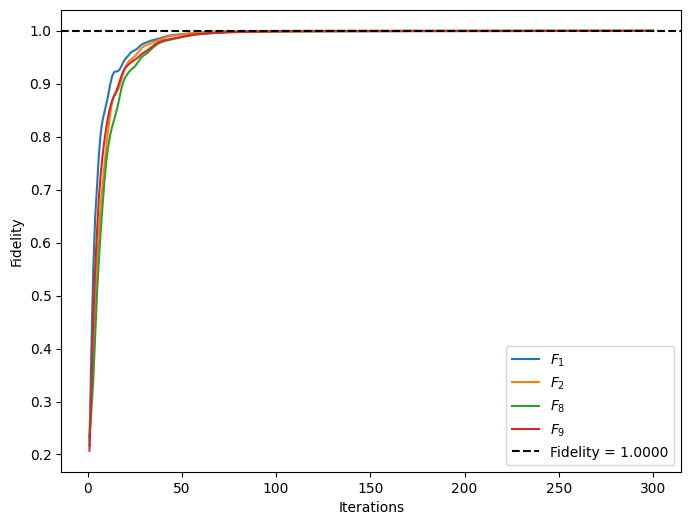

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Spat2_en1'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_12S[0, 2].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')


#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.00, 0.92), ncol=4, fontsize='small', markerscale=0.8)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_12S[0, 2].axhline(y=-1.0000, color='black', linestyle='--')
axs_12S[0, 2].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[0, 2].tick_params(axis='x', labelsize=10.5)
axs_12S[0, 2].tick_params(axis='y', labelsize=10.5)
axs_12S[0, 2].set_title('(k)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_12S[0, 3].plot(iterations, means, label=r'$F_{0}$')
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        axs_12S[0, 3].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend()
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_12S[0, 3].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[0, 3].tick_params(axis='x', labelsize=10.5)
axs_12S[0, 3].tick_params(axis='y', labelsize=10.5)
axs_12S[0, 3].legend()
axs_12S[0, 3].set_title('(l)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend()
#axs[1, 0].set_title('(c)', loc='left', pad=8)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper right', bbox_to_anchor=(1.00, 0.97))
#axs[1, 1].set_title('(d)', loc='left', pad=8)

plt.tight_layout()
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.00))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 0.94))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_en0:

The first iteration where Fidelity_excited_4 reaches or exceeds fidelity 0.99 is at iteration 1


<Figure size 640x480 with 0 Axes>

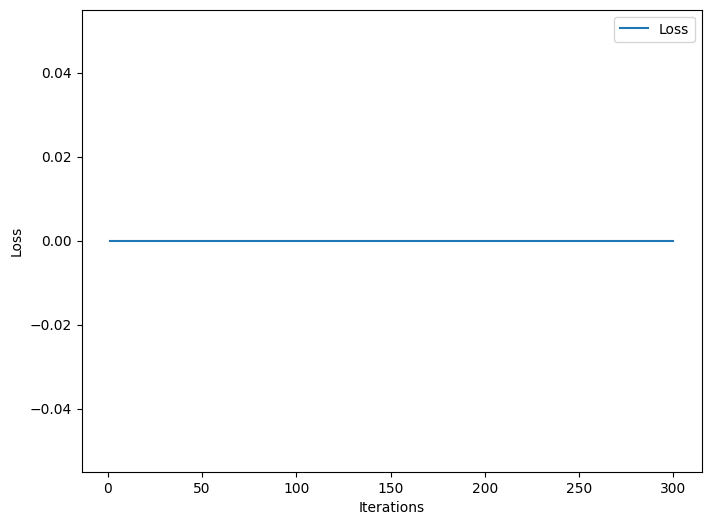

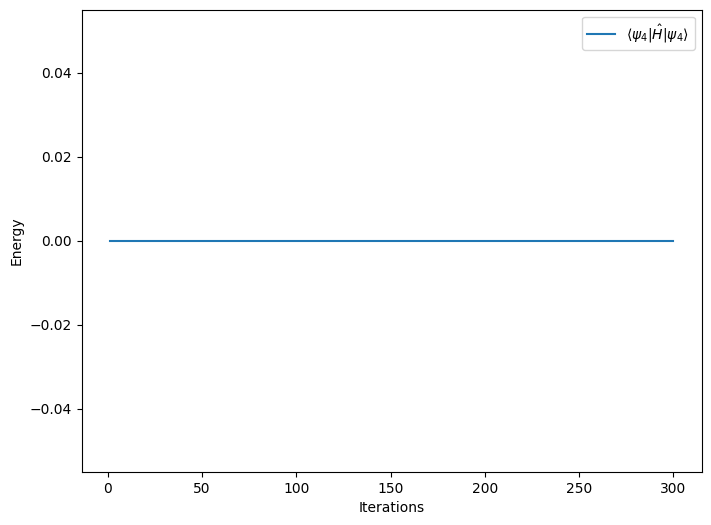

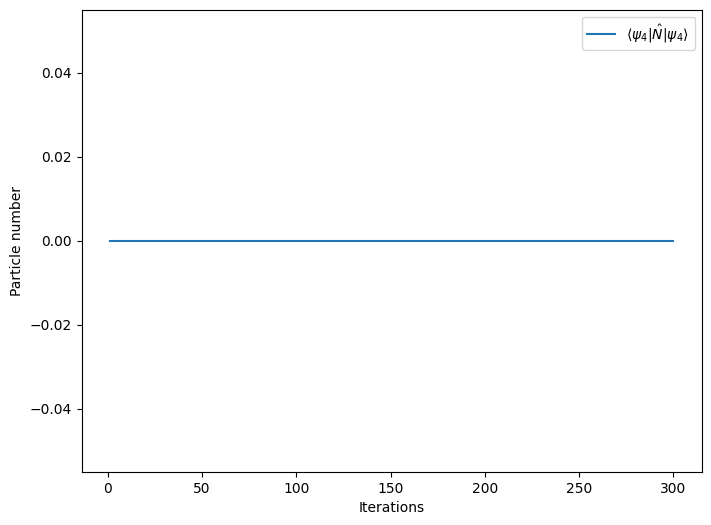

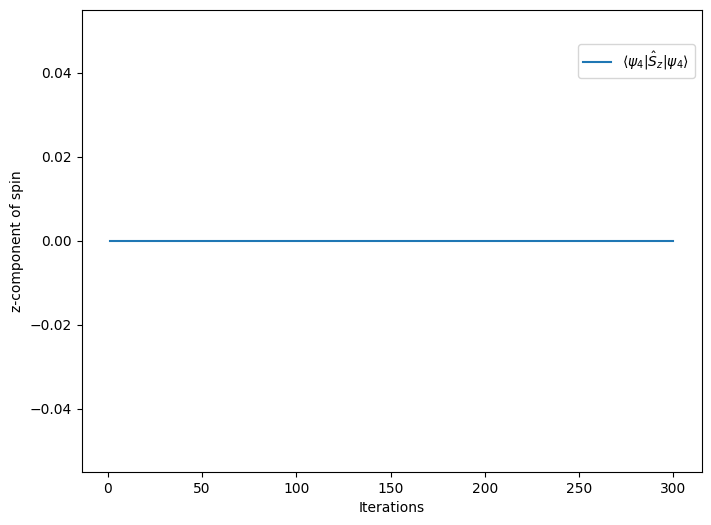

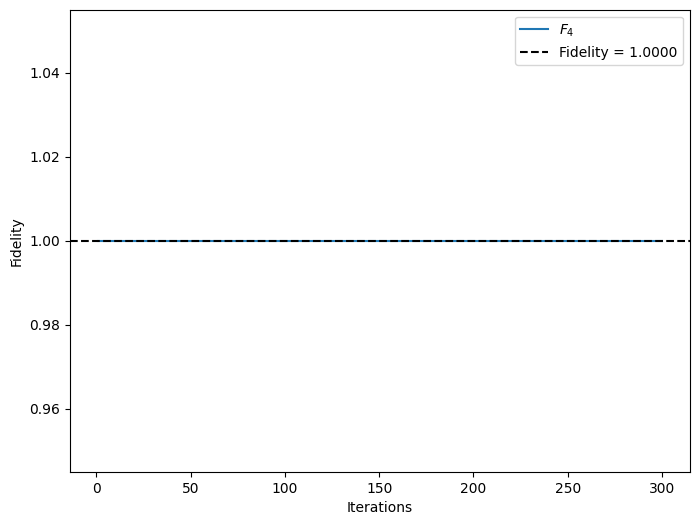

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Spat2_en0'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_12S[1, 0].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')


#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.00, 0.92), ncol=4, fontsize='small', markerscale=0.8)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_12S[1, 0].axhline(y=0.0000, color='black', linestyle='--')
axs_12S[1, 0].set_ylabel('Energy', fontsize=15)
axs_12S[1, 0].tick_params(axis='x', labelsize=10.5)
axs_12S[1, 0].tick_params(axis='y', labelsize=10.5)
axs_12S[1, 0].set_title('(m)', loc='left', pad=6, x=-0.195, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_12S[1, 1].plot(iterations, means, label=r'$F_{0}$')
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        axs_12S[1, 1].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend()
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_12S[1, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[1, 1].set_ylabel('Fidelity', fontsize=15)
axs_12S[1, 1].tick_params(axis='x', labelsize=10.5)
axs_12S[1, 1].tick_params(axis='y', labelsize=10.5)
axs_12S[1, 1].legend()
axs_12S[1, 1].set_title('(n)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend()
#axs[1, 0].set_title('(c)', loc='left', pad=8)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper right', bbox_to_anchor=(1.00, 0.97))
#axs[1, 1].set_title('(d)', loc='left', pad=8)

plt.tight_layout()
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.00))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 0.94))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_en3:

The first iteration where Fidelity_excited_7 reaches or exceeds fidelity 0.99 is at iteration 42
The first iteration where Fidelity_excited_10 reaches or exceeds fidelity 0.99 is at iteration 44
The first iteration where Fidelity_excited_12 reaches or exceeds fidelity 0.99 is at iteration 51
The first iteration where Fidelity_excited_13 reaches or exceeds fidelity 0.99 is at iteration 51


<Figure size 640x480 with 0 Axes>

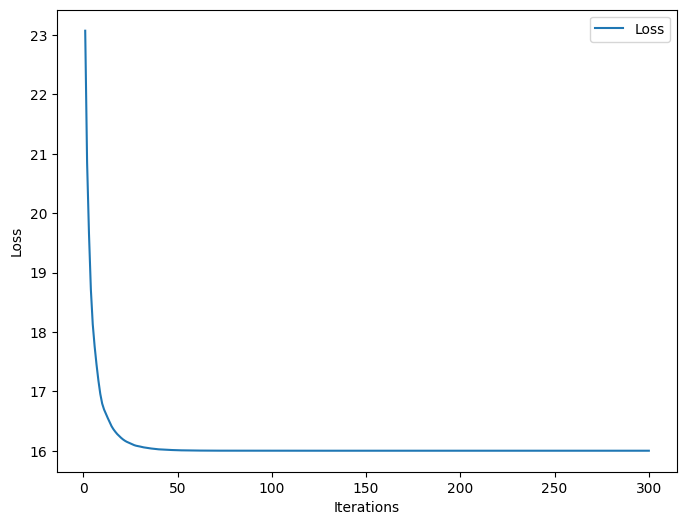

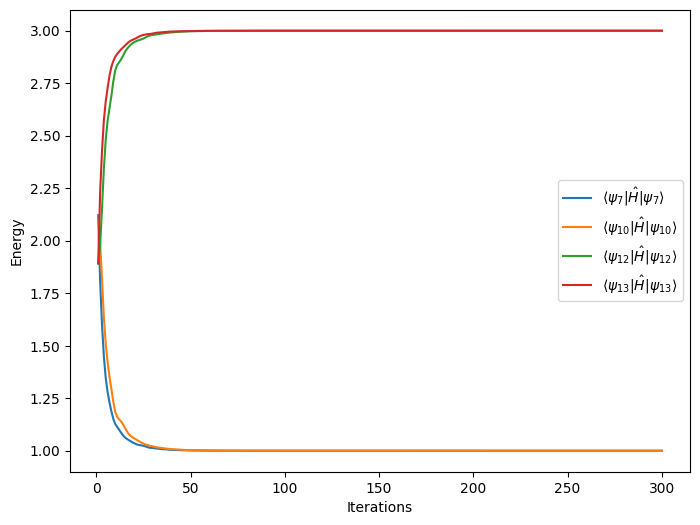

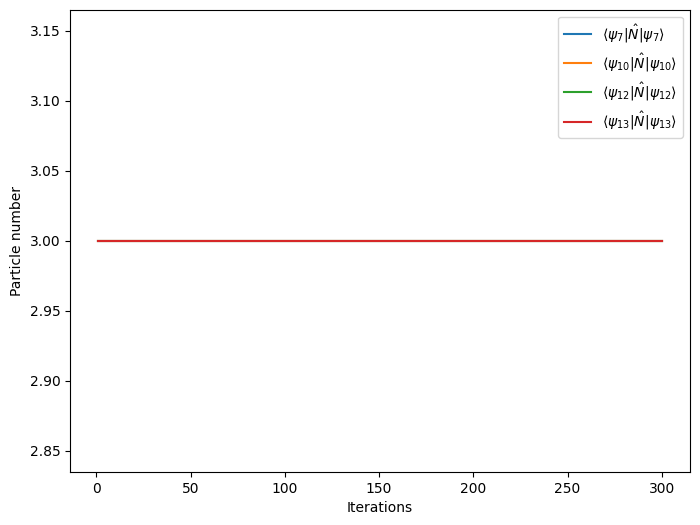

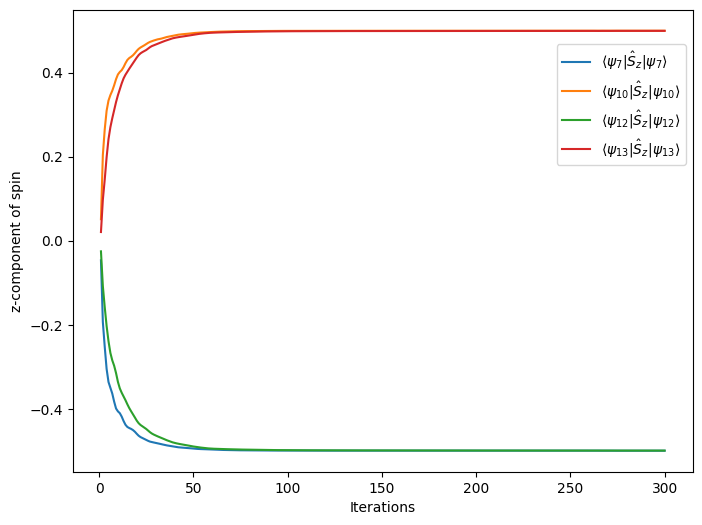

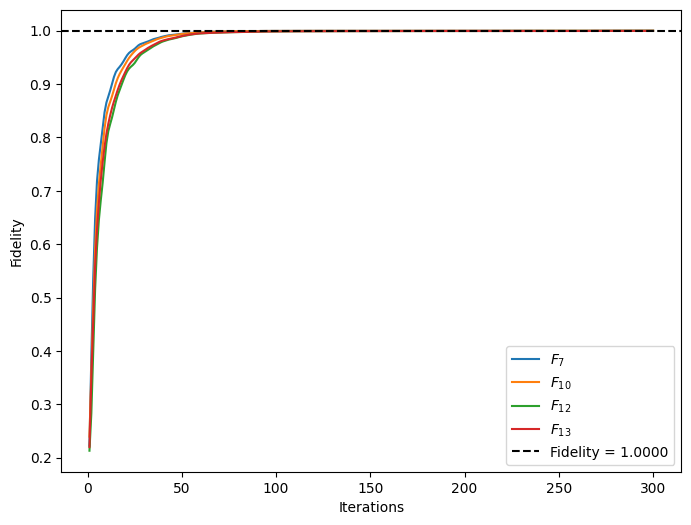

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Spat2_en3'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_12S[1, 2].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')


#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.00, 0.92), ncol=4, fontsize='small', markerscale=0.8)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_12S[1, 2].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[1, 2].axhline(y=3.0000, color='black', linestyle='--')
axs_12S[1, 2].set_ylabel('Energy', fontsize=15)
axs_12S[1, 2].tick_params(axis='x', labelsize=10.5)
axs_12S[1, 2].tick_params(axis='y', labelsize=10.5)
axs_12S[1, 2].set_title('(o)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_12S[1, 3].plot(iterations, means, label=r'$F_{0}$')
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        axs_12S[1, 3].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend()
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_12S[1, 3].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[1, 3].set_ylabel('Fidelity', fontsize=15)
axs_12S[1, 3].tick_params(axis='x', labelsize=10.5)
axs_12S[1, 3].tick_params(axis='y', labelsize=10.5)
axs_12S[1, 3].legend()
axs_12S[1, 3].set_title('(p)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend()
#axs[1, 0].set_title('(c)', loc='left', pad=8)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper right', bbox_to_anchor=(1.00, 0.97))
#axs[1, 1].set_title('(d)', loc='left', pad=8)

plt.tight_layout()
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.00))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 0.94))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
1D_Spat2_en4:

The first iteration where Fidelity_excited_15 reaches or exceeds fidelity 0.99 is at iteration 1


<Figure size 640x480 with 0 Axes>

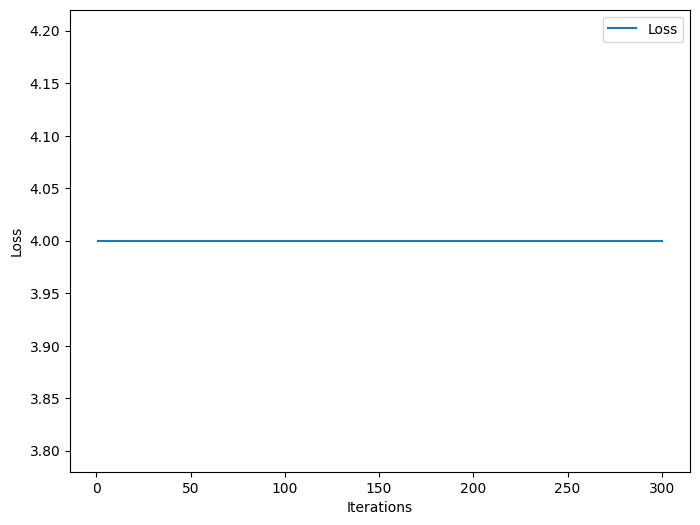

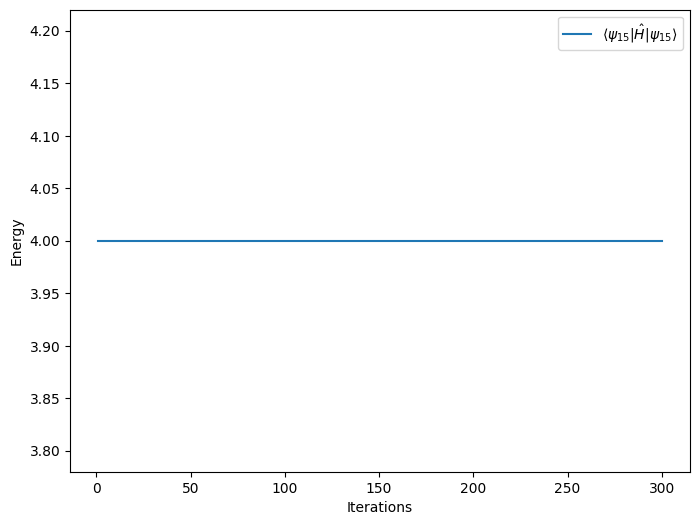

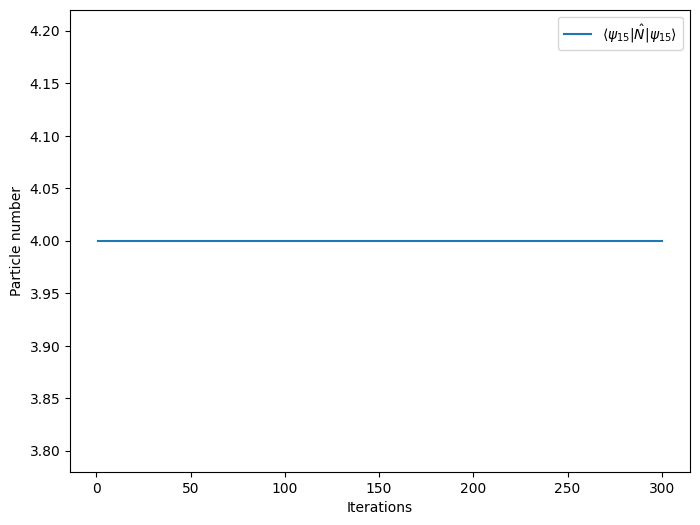

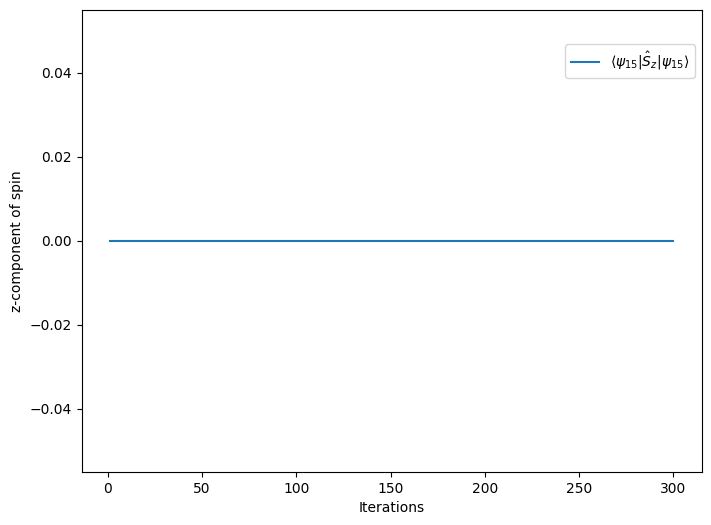

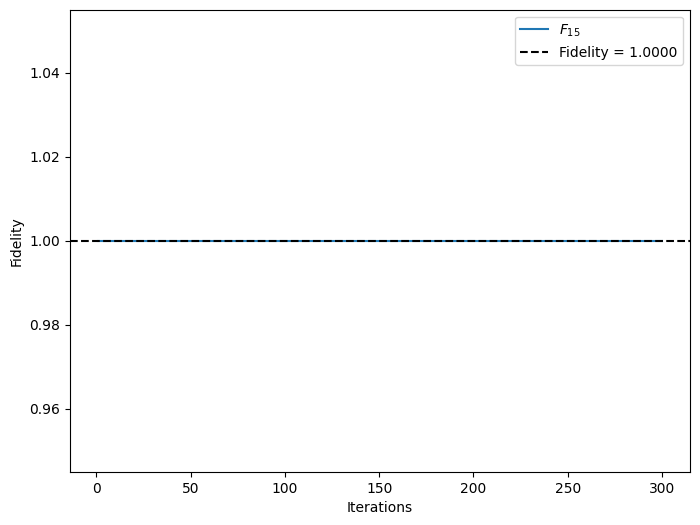

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

process = 'Spat2_en4'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_1D_{process}")
files = glob.glob(f'{folder_path}/{process}_*')

# Dictionary for storing results
results = {}

fv = 0.99
# Dictionary to store the first iteration where each fidelity reaches or exceeds fv
first_fidelity_threshold_iterations = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # number of iterations
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # values of NumOp_psi, Sz_psi, E, Fidelity, and Loss
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            
            # Modify fidelity match to capture both ground state and excited states
            fidelity_ground_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)
            fidelity_excited_match = re.search(r'Fidelity of excited state (\d+): ([\d.-]+)', line)
            
            # Capture loss
            loss_match = re.search(r'loss: ([\d.-]+)', line)
            
            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)

            # Capture Fidelity of ground state
            if fidelity_ground_match:
                fidelity_value = float(fidelity_ground_match.group(1))
                results[iter_num].setdefault('Fidelity_ground', []).append(fidelity_value)
            
            # Capture Fidelity of excited states
            if fidelity_excited_match:
                excited_state_index = int(fidelity_excited_match.group(1))
                fidelity_value = float(fidelity_excited_match.group(2))
                results[iter_num].setdefault(f'Fidelity_excited_{excited_state_index}', []).append(fidelity_value)
                
            # Capture loss
            if loss_match:
                loss_value = float(loss_match.group(1))
                results[iter_num].setdefault('Loss', []).append(loss_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

        # Check if the mean fidelity reaches or exceeds fv for the first time and record the iteration
        if "Fidelity" in key and mean_value >= fv:
            if key not in first_fidelity_threshold_iterations:
                first_fidelity_threshold_iterations[key] = iter_num

# Output the first iteration where each fidelity reaches or exceeds fv
for fidelity_key, iteration in first_fidelity_threshold_iterations.items():
    print(f"The first iteration where {fidelity_key} reaches or exceeds fidelity {fv} is at iteration {iteration}")

# Create a combined plot
#fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Energy vs Iterations
for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        #axs[0, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')
        axs_12S[2, 0].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')


#axs[0, 0].set_xlabel('Iterations')
#axs[0, 0].set_ylabel('Energy')
#axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.00, 0.92), ncol=4, fontsize='small', markerscale=0.8)
#axs[0, 0].set_title('(a)', loc='left', pad=8)

axs_12S[2, 0].axhline(y=4.0000, color='black', linestyle='--')
axs_12S[2, 0].tick_params(axis='x', labelsize=10.5)
axs_12S[2, 0].tick_params(axis='y', labelsize=10.5)
axs_12S[2, 0].set_title('(q)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot Fidelity vs Iterations
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    #axs[0, 1].plot(iterations, means, label=r'$F_{0}$')
    axs_12S[2, 1].plot(iterations, means, label=r'$F_{0}$')
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        axs_12S[2, 1].plot(iterations, means, label=rf'$\vert\psi_{{{idx}}}\rangle$')

#axs[0, 1].axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#axs[0, 1].set_xlabel('Iterations')
#axs[0, 1].set_ylabel('Fidelity')
#axs[0, 1].legend()
#axs[0, 1].set_title('(b)', loc='left', pad=8)

axs_12S[2, 1].axhline(y=1.0000, color='black', linestyle='--')
axs_12S[2, 1].tick_params(axis='x', labelsize=10.5)
axs_12S[2, 1].tick_params(axis='y', labelsize=10.5)
axs_12S[2, 1].legend()
axs_12S[2, 1].set_title('(r)', loc='left', pad=6, x=-0.15, fontsize=16)

# Plot NumOp vs Iterations
for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        #axs[1, 0].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 0].set_xlabel('Iterations')
#axs[1, 0].set_ylabel('Particle number')
#axs[1, 0].legend()
#axs[1, 0].set_title('(c)', loc='left', pad=8)

# Plot Sz vs Iterations
for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        #axs[1, 1].plot(iterations, means, label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#axs[1, 1].set_xlabel('Iterations')
#axs[1, 1].set_ylabel('z-component of spin')
#axs[1, 1].legend(loc='upper right', bbox_to_anchor=(1.00, 0.97))
#axs[1, 1].set_title('(d)', loc='left', pad=8)

plt.tight_layout()
fig_12S.delaxes(axs_12S[2, 2])
fig_12S.delaxes(axs_12S[2, 3])
fig_12S.subplots_adjust(wspace=0.43)
save_dir = os.path.expanduser('~/Desktop/Picture')
os.makedirs(save_dir, exist_ok=True)

#fig_save_path = os.path.join(save_dir, f"{process}_4_2.pdf")
#fig.savefig(fig_save_path, format='pdf', dpi=300)

fig_12S.text(0.5, 0.07, 'Iterations', ha='center', va='top', fontsize=16.5)
fig_12S_save_path = os.path.join(save_dir, f'1D_Spat2_all_eigenstates.pdf')
fig_12S.savefig(fig_12S_save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot the graph: Loss vs Iterations
plt.figure(figsize=(8, 6))

if 'Loss' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Loss'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Loss')

#plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: E vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'E{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'E{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]
        
        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{H}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Energy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid(False)
plt.show()

# Plot the graph: NumOp vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'NumOp_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'NumOp_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{N}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('Particle number vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Particle number')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.00))
plt.grid(False)
plt.show()

# Plot the graph: Sz vs Iterations
plt.figure(figsize=(8, 6))

for idx in range(16):
    if f'Sz_psi{idx}' in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[f'Sz_psi{idx}'])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, 
                 label=rf'$\langle\psi_{{{idx}}}\vert\hat{{S}}_{{z}}\vert\psi_{{{idx}}}\rangle$')

#plt.title('z-component of spin vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('z-component of spin')
plt.legend(loc='upper right', bbox_to_anchor=(1.00, 0.94))
plt.grid(False)
plt.show()

# Plot the graph: Fidelity vs Iterations
plt.figure(figsize=(8, 6))

# Plot Fidelity of ground state
if 'Fidelity_ground' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity_ground'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]

    # Plot the means
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')

# Plot Fidelity of excited states
for idx in range(1, 16):
    fidelity_key = f'Fidelity_excited_{idx}'
    if fidelity_key in mean_std_results:
        iterations, means, errors = zip(*mean_std_results[fidelity_key])
        iterations = np.array(iterations)
        means = np.array(means)
        errors = np.array(errors)

        # Choose iterations based on the error bar interval
        sampled_iterations = iterations[::error_bar_interval]
        sampled_means = means[::error_bar_interval]
        sampled_errors = errors[::error_bar_interval]

        # Plot the means
        plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label=rf'$F_{{{idx}}}$')

plt.axhline(y=1.0000, color='black', linestyle='--', label='Fidelity = 1.0000')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()
